# project_ef21_extension: plotting scripts

In [2]:
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
import time
import sys
import os
import argparse
from numpy.random import normal, uniform
from sklearn.datasets import make_spd_matrix, make_sparse_spd_matrix, load_svmlight_file, dump_svmlight_file
from numpy.linalg import norm
import itertools
from scipy.special import binom
from scipy.stats import ortho_group
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
from matplotlib import pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file
import datetime
from IPython import display
from logreg_functions_fast import *

from contextlib import redirect_stdout
import shutil
import subprocess

In [92]:
import matplotlib.ticker as tck

# New plotter

In [24]:
def set_best_params_total(dataset, n, exp_name):
    #rewrite them in such a way to return several discts
    ef21_fg_bpt = {
        "mushrooms":{ 20:{'k': [2], 'factor': [1024]}, 100:{'k': [1],  'factor': [1024]}},
        "w8a":      { 20:{'k': [1], 'factor': [64]  }, 100:{'k': [16], 'factor': [64]}},
        "a9a":      { 20:{'k': [4], 'factor': [64]  }, 100:{'k': [1],  'factor': [128]}},
        "phishing": { 20:{'k': [1], 'factor': [16]  }, 100:{'k': [1],  'factor': [16]}}
    }
    
    ef21_hb_bpt = {
        "mushrooms":{ 20:{'k': [1], 'factor': [512.0], 'eta': [0.25]} },
        "w8a":      { 20:{'k': [1], 'factor': [64.0], 'eta': [0.1]} },
        "a9a":      { 20:{'k': [1], 'factor': [64.0], 'eta': [0.25]} },
        "phishing": { 20:{'k': [1], 'factor': [8.0], 'eta': [0.4]} }
    }
    hb_bpt = {
        "mushrooms":{ 20:{'factor': [2048.0], 'eta': [0.55]} },
        "w8a":      { 20:{'factor': [4.0], 'eta': [0.25]} },
        "a9a":      { 20:{'factor': [4.0], 'eta': [0.6]} },
        "phishing": { 20:{'factor': [2.0], 'eta': [0.15]} }
    }
    gd_bpt = {
        "mushrooms":{ 20:{'factor': [4096.0]} },
        "w8a":      { 20:{'factor': [4.0]} },
        "a9a":      { 20:{'factor': [2.0]} },
        "phishing": { 20:{'factor': [1.0]} }
    }
   
    ef21_page_bpt = {
        "mushrooms":{ 20:{'k': [2], 'factor': [512.0], "prb":[0.25] }},
        "w8a":      { 20:{'k': [4], 'factor': [64.0],  "prb":[0.03]  }},
        "a9a":      { 20:{'k': [2], 'factor': [128.0], "prb":[0.015]  }},
        "phishing": { 20:{'k': [1], 'factor': [16.0],  "prb":[0.007]  }}
    }
    
    ef21_sgd_bpt = {
        "mushrooms":{ 20:{'k': [2], 'factor': np.array([2048],dtype=float), "prb": [0.25] }},
        "w8a":      { 20:{'k': [4], 'factor': np.array([1024],dtype=float),  "prb": [0.03]  }},
        "a9a":      { 20:{'k': [2], 'factor': np.array([2048],dtype=float), "prb": [0.015]  }},
        "phishing": { 20:{'k': [1], 'factor': np.array([2048],dtype=float),  "prb": [0.007]  }}
    }
    
    ef21_pp_bpt = {
        "mushrooms":{ 100:{'k': [8], 'factor': np.array([64.0],dtype=float), "prw": [0.125] }},
        "w8a":      { 100:{'k': [32], 'factor': np.array([64.0],dtype=float),  "prw": [0.5]  }},
        "a9a":      { 100:{'k': [8], 'factor': np.array([32.0],dtype=float), "prw": [0.25]  }},
        "phishing": { 100:{'k': [1], 'factor': np.array([8.0],dtype=float),  "prw": [0.5]  }}
    }
    
    ef21_bc_bpt  = {
        "mushrooms":{ 20:{"k_od": [1], "k_bd": [2],"factor":[512.0]}},
        "w8a":      { 20:{"k_od": [8], "k_bd": [8],"factor":[32.0]}},
        "a9a":      { 20:{"k_od": [4], "k_bd": [8],"factor":[64.0]}},
        "phishing": { 20:{"k_od": [8], "k_bd": [8],"factor":[8.0]}},
    }
    
    opt_dict = {"ef21_fg":   lambda dataset, n: ef21_fg_bpt[dataset][n],
                "ef21_hb":   lambda dataset, n: ef21_hb_bpt[dataset][n],
                "gd":        lambda dataset, n: gd_bpt[dataset][n],
                "hb":        lambda dataset, n: hb_bpt[dataset][n],
                "ef21_page": lambda dataset, n: ef21_page_bpt[dataset][n],
                "ef21_sgd":  lambda dataset, n: ef21_sgd_bpt[dataset][n],
                "ef21_pp":   lambda dataset, n: ef21_pp_bpt[dataset][n],
                "ef21_bc":   lambda dataset, n: ef21_bc_bpt[dataset][n]
               }

    return opt_dict[exp_name](dataset, n)

In [124]:
myrepr = lambda x: repr(round(x, 4)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding
intrepr = lambda x: int(x) if x.is_integer() else round(x,4) 
########################################
## LOGS UPLOADER (BY GIVEN EXPS_STRS) ##
########################################
def upload_logs (dataset, experiment_ar, label_ar, x_axis, y_axis, ub_x_axis):
    its_last_value = np.zeros(len(experiment_ar))
    its_ar = []
    norms_ar = []
    
    for i, experiment in enumerate(experiment_ar):
        logs_path = project_path + "logs/logs_{0}_{1}/".format(dataset, experiment)
        #temporary fix for sgd exp
        logs_file_its = logs_path + x_axis + "_" + experiment + ".npy"
        if os.path.isfile(logs_file_its):
            its = np.load(logs_file_its)  
            if len (its.shape)==2:
                if its.shape[0] ==1:
                    its = its.flatten()
                else: 
                    raise ValueError("wrong shape")
            number_its = len(its[its < ub_x_axis[dataset]])
            its_ar.append(its[:number_its])
            #its_ar.append(its)
            norms = np.load(logs_path + y_axis + '_' + experiment+'.npy')
            if len (norms.shape)==2:
                if norms.shape[0]==1:
                    norms = norms.flatten()
                else: 
                    raise ValueError("wrong shape")
            norms_ar.append(norms[:number_its])
            #norms_ar.append(norms)
            
            its_last_value[i] = its_ar[-1][-1]
        else: 
            print (logs_path +" "+ experiment+" is not computed")
        if print_each_exp:
            print ("%34s iter: %8d; norms: %9.2e  bits/n: %8d"%(label_ar[i], its_ar[-1].shape[0], norms_ar[-1][-1], its_ar[-1][-1]) )        
    it_min = np.argmin (its_last_value)
    print (f"\n MIN: " + "%34s iter: %8d; norms: %9.2e  bits/n: %8d \n"%(label_ar[it_min], its_ar[it_min].shape[0], norms_ar[it_min][-1], its_last_value[it_min]))
    print ("Num exps: ",len(label_ar))
    return its_ar, norms_ar 

#############################################
##  EXPS_STRS GENERATORS (BY GIVEN PARAMS) ##
#############################################

def ef21_fg_exp_label(n_ar, ef21_fg_dict, main_title):
    ef21_fg_k_ar, ef21_fg_factor_ar = ef21_fg_dict["k"], ef21_fg_dict["factor"]
    exp_ef21_fg_ar = ["biased-diana-full-grad_nw-{0}_{1}x_{2}".format(n, ef21_fg_factor, k) for n, k, ef21_fg_factor in itertools.product(n_ar, ef21_fg_k_ar, ef21_fg_factor_ar)]
    label_ef21_fg_ar = {"comparison_best":["EF21; Top-{0}; {1}x".format(k, ef21_fg_factor) for n, k, ef21_fg_factor in itertools.product(n_ar, ef21_fg_k_ar, ef21_fg_factor_ar)],
                        "comparison_per_k":["EF21; {0}x".format(ef21_fg_factor) for n, k, ef21_fg_factor in itertools.product(n_ar, ef21_fg_k_ar, ef21_fg_factor_ar)]}[main_title]
    return exp_ef21_fg_ar, label_ef21_fg_ar

def ef21_hb_exp_label(n_ar, ef21_hb_dict, main_title):
    ef21_hb_k_ar, ef21_hb_factor_ar, ef21_hb_eta_ar = ef21_hb_dict["k"], ef21_hb_dict["factor"], ef21_hb_dict["eta"],
    exp_ef21_hb_ar = ["ef21-hb_nw-{0}_{1}x_e-{2}_{3}".format(n, myrepr(ef21_hb_factor),myrepr(eta), k) for n, k, ef21_hb_factor, eta in itertools.product(n_ar, ef21_hb_k_ar, ef21_hb_factor_ar,ef21_hb_eta_ar)]
    label_ef21_hb_ar = {"comparison_best":[r"EF21-HB; Top-{0}; {1}x; $\eta={2}$".format(k, int(ef21_hb_factor), np.round(eta,2)) for n, k, ef21_hb_factor, eta in itertools.product(n_ar, ef21_hb_k_ar, ef21_hb_factor_ar,ef21_hb_eta_ar)],
                       "comparison_per_k":[r"EF21-HB; {0}x; $\eta={1}$".format(int(ef21_hb_factor), np.round(eta,2)) for n, k, ef21_hb_factor, eta in itertools.product(n_ar, ef21_hb_k_ar, ef21_hb_factor_ar,ef21_hb_eta_ar)]}[main_title]
    return exp_ef21_hb_ar, label_ef21_hb_ar
    
def ef21_pp_exp_label(n_ar, ef21_pp_dict, main_title):
    ef21_pp_k_ar, ef21_pp_factor_ar,ef21_pp_prw_ar = ef21_pp_dict["k"], ef21_pp_dict["factor"], ef21_pp_dict["prw"]
    exp_ef21_pp_ar = ["ef21-pp_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_pp_factor), myrepr(prw), k) for n, k, ef21_pp_factor, prw in itertools.product(n_ar, ef21_pp_k_ar, ef21_pp_factor_ar,ef21_pp_prw_ar)]
    label_ef21_pp_ar = {"comparison_best":["EF21-PP; Top-{0}; {1}x; {2}%".format(k, int(ef21_pp_factor), intrepr(prw*100)) for n, k, ef21_pp_factor,prw in itertools.product(n_ar, ef21_pp_k_ar, ef21_pp_factor_ar,ef21_pp_prw_ar)],
                       "comparison_per_k":["EF21-PP; {0}x; {1}%".format(intrepr(ef21_pp_factor), intrepr(prw*100)) for n, k, ef21_pp_factor,prw in itertools.product(n_ar, ef21_pp_k_ar, ef21_pp_factor_ar,ef21_pp_prw_ar)]}[main_title]
    return exp_ef21_pp_ar, label_ef21_pp_ar 

def sgd_exp_label(n_ar, sgd_dict, main_title):
    sgd_factor_ar, sgd_prb_ar = sgd_dict["factor"],sgd_dict["prb"]
    exp_sgd_ar = ["sgd_nw-{0}_{1}x_{2}".format(n, myrepr(sgd_factor), myrepr(prb)) for n, sgd_factor, prb in itertools.product(n_ar, sgd_factor_ar,sgd_prb_ar)]
    label_sgd_ar = {"comparison_best":["SGD; {0}x; {1}%".format(int(sgd_factor), intrepr(prb*100)) for n, sgd_factor,prb in itertools.product(n_ar, sgd_factor_ar,sgd_prb_ar)],
                        "comparison_per_k":["SGD; {0}x; {1}%".format(int(sgd_factor), intrepr(prb*100)) for n, sgd_factor,prb in itertools.product(n_ar, sgd_factor_ar,sgd_prb_ar)]}[main_title]
    return exp_sgd_ar, label_sgd_ar

def ef21_sgd_exp_label(n_ar, ef21_sgd_dict, main_title):
    ef21_sgd_k_ar, ef21_sgd_factor_ar,ef21_sgd_prb_ar = ef21_sgd_dict["k"],ef21_sgd_dict["factor"],ef21_sgd_dict["prb"]
    exp_ef21_sgd_ar = ["ef21-sgd_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_sgd_factor), myrepr(prb), k) for n, k, ef21_sgd_factor, prb in itertools.product(n_ar, ef21_sgd_k_ar, ef21_sgd_factor_ar,ef21_sgd_prb_ar)]
    label_ef21_sgd_ar = {"comparison_best":["EF21-SGD; Top-{0}; {1}x; {2}%".format(k, int(ef21_sgd_factor), intrepr(prb*100)) for n, k, ef21_sgd_factor,prb in itertools.product(n_ar, ef21_sgd_k_ar, ef21_sgd_factor_ar,ef21_sgd_prb_ar)],
                        "comparison_per_k":["EF21-SGD; {0}x; {1}%".format(int(ef21_sgd_factor), intrepr(prb*100)) for n, k, ef21_sgd_factor,prb in itertools.product(n_ar, ef21_sgd_k_ar, ef21_sgd_factor_ar,ef21_sgd_prb_ar)]}[main_title]
    return exp_ef21_sgd_ar, label_ef21_sgd_ar

def page_exp_label(n_ar, page_dict, main_title):
    page_factor_ar,page_prb_ar = page_dict["factor"], page_dict["prb"],
    exp_page_ar = ["page_nw-{0}_{1}x_{2}".format(n, myrepr(page_factor), myrepr(prb)) for n, page_factor, prb in itertools.product(n_ar, page_factor_ar,page_prb_ar)]
    label_page_ar = {"comparison_best":["PAGE; {0}x; {1}%".format(int(page_factor), intrepr(prb*100)) for n, page_factor,prb in itertools.product(n_ar, page_factor_ar,page_prb_ar)],
                         "comparison_per_k":["PAGE; {0}x; {1}%".format(int(page_factor), intrepr(prb*100)) for n, page_factor,prb in itertools.product(n_ar, page_factor_ar,page_prb_ar)]}[main_title]
    return exp_page_ar, label_page_ar 

def ef21_page_exp_label(n_ar, ef21_page_dict, main_title):
    ef21_page_k_ar, ef21_page_factor_ar,ef21_page_prb_ar = ef21_page_dict["k"], ef21_page_dict["factor"], ef21_page_dict["prb"],
    exp_ef21_page_ar = ["ef21-page_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_page_factor), myrepr(prb), k) for n, k, ef21_page_factor, prb in itertools.product(n_ar, ef21_page_k_ar, ef21_page_factor_ar,ef21_page_prb_ar)]
    label_ef21_page_ar = {"comparison_best":["EF21-PAGE; Top-{0}; {1}x; {2}%".format(k, int(ef21_page_factor), intrepr(prb*100)) for n, k, ef21_page_factor,prb in itertools.product(n_ar, ef21_page_k_ar, ef21_page_factor_ar,ef21_page_prb_ar)],
                         "comparison_per_k":["EF21-PAGE; {0}x; {1}%".format(int(ef21_page_factor), intrepr(prb*100)) for n, k, ef21_page_factor,prb in itertools.product(n_ar, ef21_page_k_ar, ef21_page_factor_ar,ef21_page_prb_ar)]}[main_title]
    return exp_ef21_page_ar, label_ef21_page_ar

def ef21_bc_exp_label (n_ar, ef21_bc_dict, main_title):
    ef21_bc_k_od_ar, ef21_bc_k_bd_ar, ef21_bc_factor_ar = ef21_bc_dict["k_od"], ef21_bc_dict["k_bd"], ef21_bc_dict["factor"]
    exp_ef21_bc_ar = ["ef21-bc_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_bc_factor), k_od, k_bd) for n, k_od, k_bd, ef21_bc_factor in itertools.product(n_ar, ef21_bc_k_od_ar, ef21_bc_k_bd_ar, ef21_bc_factor_ar)]
    label_ef21_bc_ar = {"comparison_best":[r"EF21-BC; Top-{0}(C$\rightarrow$S); Top-{1}(S$\rightarrow$C); {2}x".format(k_od, k_bd, int(ef21_bc_factor)) for n, k_od, k_bd, ef21_bc_factor in itertools.product(n_ar, ef21_bc_k_od_ar, ef21_bc_k_bd_ar, ef21_bc_factor_ar)],
                       "comparison_per_k":[r"EF21-BC; Top-{0}(S$\rightarrow$C); {1}x".format(k_bd, int(ef21_bc_factor)) for n, k_od, k_bd, ef21_bc_factor in itertools.product(n_ar, ef21_bc_k_od_ar, ef21_bc_k_bd_ar, ef21_bc_factor_ar)]}[main_title]
    return exp_ef21_bc_ar, label_ef21_bc_ar

def hb_exp_label (n_ar, hb_dict, main_title):
    hb_factor_ar, hb_eta_ar = hb_dict["factor"], hb_dict["eta"]
    exp_hb_ar = ["hb_nw-{0}_{1}x_e-{2}".format(n, myrepr(hb_factor),myrepr(eta)) for n, hb_factor, eta in itertools.product(n_ar, hb_factor_ar, hb_eta_ar)]
    label_hb_ar = [r"HB; {0}x; $\eta={1}$".format(int(hb_factor), np.round(eta,2)) for n, hb_factor, eta in itertools.product(n_ar, hb_factor_ar,hb_eta_ar)]
    return exp_hb_ar, label_hb_ar

def gd_exp_label (n_ar, gd_dict, main_title):  
    gd_factor_ar = gd_dict["factor"]
    exp_gd_ar = ["fg_nw-{0}_{1}x".format(n, myrepr(gd_factor)) for n, gd_factor in itertools.product(n_ar, gd_factor_ar)]
    label_gd_ar = ["GD; {0}x".format(int(gd_factor)) for n, gd_factor in itertools.product(n_ar, gd_factor_ar)]
    return exp_gd_ar, label_gd_ar
    
exp_and_label_list_from_dict = {"ef21_fg":   lambda n_ar, ef21_fg_dict, main_title:   ef21_fg_exp_label(n_ar, ef21_fg_dict, main_title), 
                                "ef21_hb":   lambda n_ar, ef21_hb_dict, main_title:   ef21_hb_exp_label(n_ar, ef21_hb_dict, main_title), 
                                "ef21_pp":   lambda n_ar, ef21_pp_dict, main_title:   ef21_pp_exp_label(n_ar, ef21_pp_dict, main_title) , 
                                "ef21_sgd":  lambda n_ar, ef21_sgd_dict, main_title:  ef21_sgd_exp_label(n_ar, ef21_sgd_dict, main_title), 
                                "ef21_page": lambda n_ar, ef21_page_dict, main_title: ef21_page_exp_label(n_ar, ef21_page_dict, main_title),
                                "sgd":  lambda n_ar, sgd_dict, main_title:  sgd_exp_label(n_ar, sgd_dict, main_title), 
                                "page": lambda n_ar, page_dict, main_title: page_exp_label(n_ar, page_dict, main_title),
                                "hb":        lambda n_ar, hb_dict, main_title:        hb_exp_label (n_ar, hb_dict, main_title),
                                "gd":        lambda n_ar, gd_dict, main_title:        gd_exp_label (n_ar, gd_dict, main_title),
                                "ef21_bc":   lambda n_ar, ef21_bc_dict, main_title:   ef21_bc_exp_label(n_ar, ef21_bc_dict, main_title) 
                               } 



def set_best_params_grouped_by_param(dataset, n, exp_name, param_value):
    #done
    ef21_fg_bpt = {
        "mushrooms":{ 20:{2:{'k': [2],  'factor': [1024]} }, 100:{ 2:{'k': [2],  'factor': [1024]} } },
        "w8a":      { 20:{2:{'k': [2],  'factor': [64]} }, 100:{ 2:{'k': [2], 'factor': [64]} }},
        "a9a":      { 20:{2:{'k': [2],  'factor': [64]} }, 100:{ 2:{'k': [2],  'factor': [128]} }},
        "phishing": { 20:{1:{'k': [1],  'factor': [16]} }, 100:{ 1:{'k': [1],  'factor': [16]} }},
        "realsim": { 20:{210:{'k': [210],  'factor': [64]} }, 100:{ 210:{'k': [210],  'factor': [128]} }}
    }
    
    #done
    ef21_hb_bpt = {
        "mushrooms":{ 20:{0.05:{"k":[2],"eta":[0.05], "factor":[1024.0] }, 0.2:{"k":[2],"eta":[0.2], "factor":[512.0] }, 0.25:{"k":[2],"eta":[0.25], "factor":[512.0] }, 0.4:{"k":[2],"eta":[0.4], "factor":[512.0] }, 0.9:{"k":[2],"eta":[0.9], "factor":[16.0] }}},
        "w8a":      { 20:{0.05:{"k":[2],"eta":[0.05], "factor":[64.0] }, 0.2:{"k":[2],"eta":[0.2], "factor":[64.0] }, 0.25:{"k":[2],"eta":[0.25], "factor":[64.0] }, 0.4:{"k":[2],"eta":[0.4], "factor":[32.0] }, 0.9:{"k":[2],"eta":[0.9], "factor":[4.0] } }},
        "a9a":      { 20:{0.05:{"k":[2],"eta":[0.05], "factor":[64.0] }, 0.2:{"k":[2],"eta":[0.2], "factor":[64.0] }, 0.25:{"k":[2],"eta":[0.25], "factor":[64.0] }, 0.4:{"k":[2],"eta":[0.4], "factor":[32.0] }, 0.9:{"k":[2],"eta":[0.9], "factor":[4.0] } }},
        "phishing": { 20:{0.05:{"k":[1],"eta":[0.05], "factor":[16.0] }, 0.2:{"k":[1],"eta":[0.2], "factor":[16.0] }, 0.25:{"k":[1],"eta":[0.25], "factor":[8.0] }, 0.4:{"k":[1],"eta":[0.4], "factor":[8.0] }, 0.9:{"k":[1],"eta":[0.9], "factor":[1.0] } }},
    }
    
    ef21_page_bpt = {
        "mushrooms":{ 20:{0.5:{"k":[2],"prb":[0.5], "factor":[1024.0]}, 0.25:{"k":[2],"prb":[0.25], "factor":[512.0]}, 0.125:{"k":[2],"prb":[0.125], "factor":[1024.0]}, 0.065:{"k":[2],"prb":[0.065], "factor":[1024.0] }, 0.03:{"k":[2],"prb":[0.03], "factor":[1024.0] },0.015:{"k":[2],"prb":[0.015], "factor":[1024.0]},0.007:{"k":[2],"prb":[0.007], "factor":[256.0]} }},
        "w8a":      { 20:{0.5:{"k":[2],"prb":[0.5], "factor":[64.0]}, 0.25:{"k":[2],"prb":[0.25], "factor":[64.0]}, 0.125:{"k":[2],"prb":[0.125], "factor":[64.0]},0.065:{"k":[2],"prb":[0.065], "factor":[64.0] }, 0.03:{"k":[2],"prb":[0.03], "factor":[64.0] }, 0.015:{"k":[2],"prb":[0.015], "factor":[64.0]}, 0.007:{"k":[2],"prb":[0.007], "factor":[64.0]}}},
        "a9a":      { 20:{0.5:{"k":[2],"prb":[0.5], "factor":[64.0]}, 0.25:{"k":[2],"prb":[0.25], "factor":[64.0]}, 0.125:{"k":[2],"prb":[0.125], "factor":[64.0]},0.065:{"k":[2],"prb":[0.065], "factor":[64.0] }, 0.03:{"k":[2],"prb":[0.03], "factor":[64.0] }, 0.015:{"k":[2],"prb":[0.015], "factor":[128.0]}, 0.007:{"k":[2],"prb":[0.007], "factor":[128.0]}}},
        "phishing": { 20:{0.5:{"k":[1],"prb":[0.5], "factor":[16.0]}, 0.25:{"k":[1],"prb":[0.25], "factor":[16.0]}, 0.125:{"k":[1],"prb":[0.125], "factor":[16.0]},0.065:{"k":[1],"prb":[0.065], "factor":[16.0] }, 0.03:{"k":[1],"prb":[0.03], "factor":[16.0] }, 0.015:{"k":[1],"prb":[0.015], "factor":[16.0]}, 0.007:{"k":[1],"prb":[0.007], "factor":[16.0]}}},
        "realsim": { 20:{0.25:{"k":[210],"prb":[0.25], "factor":[32.0] }, 0.125:{"k":[210],"prb":[0.125], "factor":[8.0] }, 0.015:{"k":[210],"prb":[0.015], "factor":[8.0] }}}
    }
    
    page_bpt = {"mushrooms":{20:{0.25:{"prb":[0.25], "factor":[4096.0] }, 0.125:{"prb":[0.125], "factor":[4096.0] },  }},
                    "w8a":{20:{0.25:{"prb":[0.25], "factor":[2048.0] },0.125:{"prb":[0.125], "factor":[4096.0] }, }},
                     "a9a":{20:{0.25:{"prb":[0.25], "factor":[4096.0] }, 0.125:{"prb":[0.125], "factor":[4096.0] },  }},
                     "phishing":{20:{ 0.25:{"prb":[0.25], "factor":[2048.0] }, 0.125:{"prb":[0.125], "factor":[4096.0] },}},
                    }
    
    ef21_sgd_bpt = {
        "mushrooms":{ 20:{0.5:{"k":[2],"prb":[0.5], "factor":[2048.0] }, 0.25:{"k":[2],"prb":[0.25], "factor":[2048.0] }, 0.125:{"k":[2],"prb":[0.125], "factor":[2048.0] }, 0.015:{"k":[2],"prb":[0.015], "factor":[128.0] }, 0.007:{"k":[2],"prb":[0.007], "factor":[1024.0] }}},
        "w8a":      { 20:{0.5:{"k":[2],"prb":[0.5], "factor":[32.0] }, 0.25:{"k":[2],"prb":[0.25], "factor":[2048.0] }, 0.125:{"k":[2],"prb":[0.125], "factor":[2048.0] }, 0.015:{"k":[2],"prb":[0.015], "factor":[512.0] }, 0.007:{"k":[2],"prb":[0.007], "factor":[512.0] } }},
        "a9a":      { 20:{0.5:{"k":[2],"prb":[0.5], "factor":[32.0] }, 0.25:{"k":[2],"prb":[0.25], "factor":[128.0] }, 0.125:{"k":[2],"prb":[0.125], "factor":[64.0] }, 0.015:{"k":[2],"prb":[0.015], "factor":[512.0] }, 0.007:{"k":[2],"prb":[0.007], "factor":[4096.0] }}},
        "phishing": { 20:{0.5:{"k":[1],"prb":[0.5], "factor":[16.0] },0.25:{"k":[1],"prb":[0.25], "factor":[16.0] }, 0.125:{"k":[1],"prb":[0.125], "factor":[4.0] },0.015:{"k":[1],"prb":[0.015], "factor":[16.0] }, 0.007:{"k":[1],"prb":[0.007], "factor":[2048.0] }}},
        "realsim": { 20:{0.25:{"k":[210],"prb":[0.25], "factor":[64.0] }, 0.125:{"k":[210],"prb":[0.125], "factor":[64.0] }, 0.015:{"k":[210],"prb":[0.015], "factor":[128.0] }}}
    }
    
    sgd_bpt = {"mushrooms":{20:{0.25:{"prb":[0.25], "factor":[4096.0] }, 0.125:{"prb":[0.125], "factor":[2048.0] }, 0.015:{"prb":[0.015], "factor":[2048.0] } }},
                    "w8a":{20:{0.25:{"prb":[0.25], "factor":[4096.0] }, 0.125:{"prb":[0.125], "factor":[2048.0] }, 0.015:{"prb":[0.015], "factor":[2048.0] } }},
                     "a9a":{20:{ 0.25:{"prb":[0.25], "factor":[2.0] }, 0.125:{"prb":[0.125], "factor":[2.0] }, 0.015:{"prb":[0.015], "factor":[2.0] }}},
                     "phishing":{20:{0.25:{"prb":[0.25], "factor":[1024.0] }, 0.125:{"prb":[0.125], "factor":[2048.0] }, 0.015:{"prb":[0.015], "factor":[128.0] } }},
                    }
     
    ef21_pp_bpt = {
        "mushrooms":{ 100:{0.95:{"k":[2],"prw":[0.95], "factor":[1024.0] }, 0.5:{"k":[2],"prw":[0.5], "factor":[512.0] }, 0.25:{"k":[2],"prw":[0.25], "factor":[256.0] }, 0.125:{"k":[2],"prw":[0.125], "factor":[128.0] }, 0.065:{"k":[2],"prw":[0.065], "factor":[64.0] }, 0.03:{"k":[2],"prw":[0.03], "factor":[8.0] } }},
        "w8a":      { 100:{0.95:{"k":[2],"prw":[0.95], "factor":[64.0] }, 0.5:{"k":[2],"prw":[0.5], "factor":[64.0] }, 0.25:{"k":[2],"prw":[0.25], "factor":[32.0] }, 0.125:{"k":[2],"prw":[0.125], "factor":[16.0] }, 0.065:{"k":[2],"prw":[0.065], "factor":[8.0] }, 0.03:{"k":[2],"prw":[0.03], "factor":[4.0] }}},
        "a9a":      { 100:{0.95:{"k":[2],"prw":[0.95], "factor":[128.0] }, 0.5:{"k":[2],"prw":[0.5], "factor":[64.0] }, 0.25:{"k":[2],"prw":[0.25], "factor":[32.0] }, 0.125:{"k":[2],"prw":[0.125], "factor":[16.0] }, 0.065:{"k":[2],"prw":[0.065], "factor":[8.0] }, 0.03:{"k":[2],"prw":[0.03], "factor":[4.0] }}},
        "phishing": { 100:{0.95:{"k":[1],"prw":[0.95], "factor":[16.0] }, 0.5:{"k":[1],"prw":[0.5], "factor":[8.0] }, 0.25:{"k":[1],"prw":[0.25], "factor":[4.0] }, 0.125:{"k":[1],"prw":[0.125], "factor":[2.0] }, 0.065:{"k":[1],"prw":[0.065], "factor":[1.0] }, 0.03:{"k":[1],"prw":[0.03], "factor":[0.5] }}},
        "realsim":{100:{0.5:{"k":[210],"prw":[0.5], "factor":[256.0] }, 0.25:{"k":[210],"prw":[0.25], "factor":[256.0] }, 0.125:{"k":[210],"prw":[0.125], "factor":[256.0] }, 0.065:{"k":[210],"prw":[0.065], "factor":[128.0] },}}
    }
        
    ef21_bc_bpt  = {
        "mushrooms":{ 20:{2:{"k_od":[2],"k_bd":[2], "factor":[128.0] }, 4:{"k_od":[2],"k_bd":[4], "factor":[256.0] }, 8:{"k_od":[2],"k_bd":[8], "factor":[1024.0] }, 16:{"k_od":[2],"k_bd":[16], "factor":[1024.0] }, 32:{"k_od":[2],"k_bd":[32], "factor":[1024.0] }, 64:{"k_od":[2],"k_bd":[64], "factor":[1024.0] }}},
        "w8a":      { 20:{2:{"k_od":[2],"k_bd":[2], "factor":[32.0] }, 4:{"k_od":[2],"k_bd":[4], "factor":[64.0] }, 8:{"k_od":[2],"k_bd":[8], "factor":[64.0] }, 16:{"k_od":[2],"k_bd":[16], "factor":[64.0] }, 32:{"k_od":[2],"k_bd":[32], "factor":[64.0] }, 64:{"k_od":[2],"k_bd":[64], "factor":[64.0] } }},
        "a9a":      { 20:{2:{"k_od":[2],"k_bd":[2], "factor":[32.0] }, 4:{"k_od":[2],"k_bd":[4], "factor":[64.0] }, 8:{"k_od":[2],"k_bd":[8], "factor":[64.0] }, 16:{"k_od":[2],"k_bd":[16], "factor":[64.0] }, 32:{"k_od":[2],"k_bd":[32], "factor":[64.0] }, 64:{"k_od":[2],"k_bd":[64], "factor":[64.0] }}},
        "phishing": { 20:{2:{"k_od":[1],"k_bd":[2], "factor":[16.0] }, 4:{"k_od":[1],"k_bd":[4], "factor":[16.0] }, 8:{"k_od":[1],"k_bd":[8], "factor":[16.0] }, 16:{"k_od":[1],"k_bd":[16], "factor":[16.0] }, 32:{"k_od":[1],"k_bd":[32], "factor":[16.0] }, 64:{"k_od":[1],"k_bd":[64], "factor":[16.0] }}},
        "realsim":{20:{210:{"k_od":[210],"k_bd":[210], "factor":[32.0] }, 1050:{"k_od":[210],"k_bd":[1050], "factor":[64.0] }, 2100:{"k_od":[210],"k_bd":[2100], "factor":[64.0] }, 5250:{"k_od":[210],"k_bd":[5250], "factor":[32.0] } }}
        }
    
    opt_dict = {"ef21_fg":   lambda dataset, n, param_value: ef21_fg_bpt[dataset][n][param_value],
                "ef21_hb":   lambda dataset, n, param_value: ef21_hb_bpt[dataset][n][param_value],
                "ef21_page": lambda dataset, n, param_value: ef21_page_bpt[dataset][n][param_value],
                "ef21_sgd":  lambda dataset, n, param_value: ef21_sgd_bpt[dataset][n][param_value],
                "page": lambda dataset, n, param_value: page_bpt[dataset][n][param_value],
                "sgd":  lambda dataset, n, param_value: sgd_bpt[dataset][n][param_value],
                "ef21_pp":   lambda dataset, n, param_value: ef21_pp_bpt[dataset][n][param_value],
                "ef21_bc":   lambda dataset, n, param_value: ef21_bc_bpt[dataset][n][param_value]
               }

    return opt_dict[exp_name](dataset, n, param_value)

def sub_dict (dct, keys ):
    return { k:v for k,v in dct.items() if k in keys }

def set_params (dataset, n_ar, exp_subdict, main_title): 
    n = n_ar[0]
    all_exps_ar = []
    all_labels_ar = []
    #
    for exp_name, exp_dict in exp_subdict.items():
        exp_ar, label_ar = [],[]
        #print(f"exp_dict: {exp_subdict} \n")
        if best_params:
            if len(exp_dict["fixed_params"])==0:
                exp_dict_best = set_best_params_total(dataset, n, exp_name)
                exp_ar, label_ar = exp_and_label_list_from_dict[exp_name] (n_ar, exp_dict_best, main_title)
                
            elif len(exp_dict["fixed_params"])==1:
                fixed_param_str = exp_dict["fixed_params"][0]      
                for param_value in exp_dict[fixed_param_str]:
                    exp_dict_best_per_param = set_best_params_grouped_by_param(dataset, n, exp_name, param_value)
                    #print(f"exp_name: {exp_name} \n")
                    #print(f"exp_dict_best_per_param: {exp_dict_best_per_param} \n")
                    exp_temp_ar, label_temp_ar = exp_and_label_list_from_dict[exp_name](n_ar, exp_dict_best_per_param, main_title)
                    #print(f"exp_temp_ar, label_temp_ar: {exp_temp_ar}, {label_temp_ar} \n" )
                    
                    exp_ar += exp_temp_ar
                    label_ar += label_temp_ar
            else:
                raise ValueError("not implemented yet")
        
        else:
            raise ValueError("not implemented yet")
        all_exps_ar += exp_ar
        all_labels_ar += label_ar
        #print("all_exps_ar: ", all_exps_ar)
        #print("all_labels_ar: ", all_labels_ar)
        
    return all_exps_ar, all_labels_ar

# Merged plots

In [34]:
n_w = 20
n_total = 72309
n = np.full(n_w, int(n_total/n_w))
n[-1] += n_total%n_w
prb_ar = [0.25,0.125,0.015,]
#print (n)
for prb in prb_ar:
    tau_ar = np.array(n*prb).astype(dtype=int)
    prob = np.mean(tau_ar/(tau_ar + n))
    print(round (prob,4))

0.1999
0.1109
0.0147


In [ ]:
#updated 
def draw_axis_and_safe(fig_ax_ar, dataset_ar, plot_path, filename, x_label, y_label, plots_titles,legend_location):
    size = 40
    marker_size = 30
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'FreeSerif'
    plt.rcParams['lines.linewidth'] = 4
    # plt.rcParams['lines.markersize'] = 10
    plt.rcParams['xtick.labelsize'] = size  # 40
    plt.rcParams['ytick.labelsize'] = size  # 40
    plt.rcParams['legend.fontsize'] = 30  # 30
    plt.rcParams['axes.titlesize'] = size  # 40
    plt.rcParams['axes.labelsize'] = size  # 40
    plt.rcParams["figure.figsize"] = [64,10]
    #plt.rcParams["figure.figsize"] = [70,10]
    
    (fig, axs) = fig_ax_ar
    limits = [  (4.34428465891723e-08, 6.416193077774576),
                (4.34428465891723e-08, 6.416193077774576),
                (4.34428465891723e-08, 6.416193077774576),
                (4.34428465891723e-08, 6.416193077774576)]
    
    """limits = [  (4.34428465891723e-08, 6.416193077774576),
                (4.24428465891723e-08, 6.416193077774576),
                (4.046518656012781e-08, 4.451998933407347),
                (4.4622215557011e-08, 1.835014420064966)]"""
    for dataset_num in range(len(dataset_ar)):
        axs[dataset_num].set_title(f"{plots_titles[dataset_num]}")#; $n$ = {n_ar[0]}")
        axs[dataset_num].set(xlabel=x_label, ylabel=y_label)
        #axs[dataset_num].set_ylabel('#bits/n', fontsize = 40.0) # Y label
        #axs[dataset_num].set_xlabel(r"$\|| \nabla f(x^t) \||^2$", fontsize = 40) # X label
        
        axs[dataset_num].set_yscale('log')
        #legend = axs[dataset_num].legend(loc="lower left", framealpha=0.5)
        #legend = axs[dataset_num].legend(loc="upper right", framealpha=0.5)
        legend = axs[dataset_num].legend(loc=legend_location[dataset_num], framealpha=0.5)
        #if dataset_ar[dataset_num] == "a9a":
        #    legend = axs[dataset_num].legend(loc="lower left", framealpha=0.5)
        axs[dataset_num].grid()
        axs[dataset_num].locator_params(axis='x', nbins=4)
        axs[dataset_num].xaxis.set_minor_locator(tck.AutoMinorLocator(5))

        locmin = tck.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=10)
        axs[dataset_num].yaxis.set_minor_locator(locmin)
        axs[dataset_num].yaxis.set_minor_formatter(tck.NullFormatter())
        axs[dataset_num].set_ylim(limits[dataset_num])
        #print(axs[dataset_num].get_ylim())
    where = plot_path + "_0_" + filename
    print(f"saving to: {where}...")
    fig.savefig(plot_path + "_0_" + filename, bbox_inches='tight')
    plt.show()
    print(f"saving is finished!")


In [147]:
{'mushrooms': int (20_000/(210*32)), 'w8a':  int (100_000/(210*32)), 'a9a':  int (50_000/(210*32)), 'phishing':  int (20_000/(210*32)), 'realsim':  int (50_000/(210*32))}

{'mushrooms': 2, 'w8a': 14, 'a9a': 7, 'phishing': 2, 'realsim': 7}

mushrooms

 MIN:                 PAGE; 4096x; 12.5% iter:       63; norms:  2.30e-08  bits/n:       89 

Num exps:  4
w8a

 MIN:              EF21-PAGE; 64x; 12.5% iter:     1425; norms:  9.75e-08  bits/n:      462 

Num exps:  4
a9a

 MIN:              EF21-PAGE; 64x; 12.5% iter:      496; norms:  9.98e-08  bits/n:      165 

Num exps:  4
phishing

 MIN:              EF21-PAGE; 16x; 12.5% iter:      404; norms:  9.98e-08  bits/n:      130 

Num exps:  4
saving to: /Users/igorsokolov/Google_Drive/KAUST/RESEARCH/5_EF21_ext/GN_most_recent_exps/plot_all-datasets/_0_comparison_per_k_iteration_epochs_page-ef21_page_0,25-0,125.pdf...


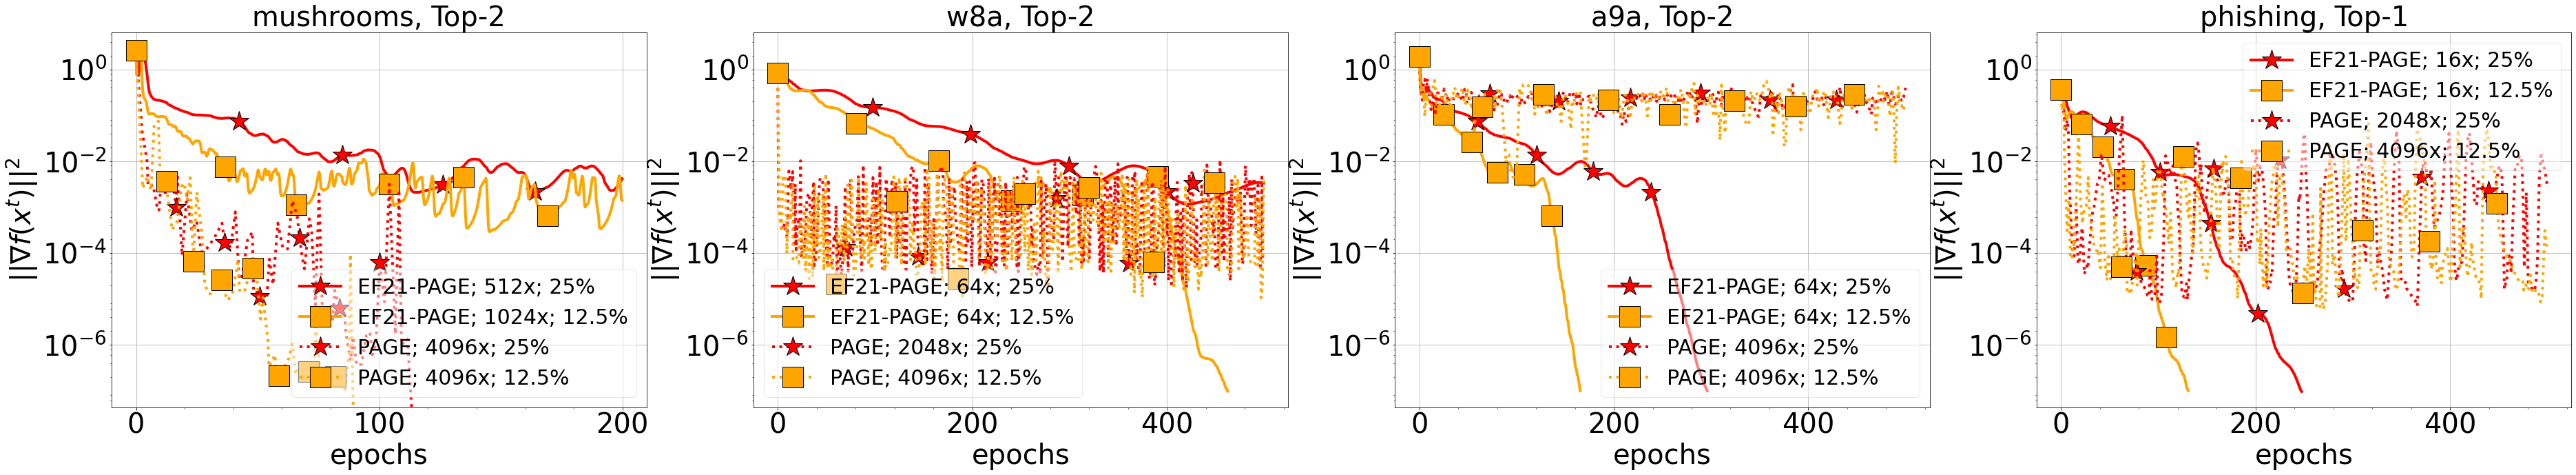

saving is finished!


In [152]:
#backup
def draw_axis_and_safe(fig_ax_ar, dataset_ar, plot_path, filename, x_label, y_label, plots_titles,legend_location):
    size = 40
    marker_size = 30
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'FreeSerif'
    plt.rcParams['lines.linewidth'] = 4
    # plt.rcParams['lines.markersize'] = 10
    plt.rcParams['xtick.labelsize'] = size  # 40
    plt.rcParams['ytick.labelsize'] = size  # 40
    plt.rcParams['legend.fontsize'] = 30  # 30
    plt.rcParams['axes.titlesize'] = size  # 40
    plt.rcParams['axes.labelsize'] = size  # 40
    if len(dataset_ar)==4:
        plt.rcParams["figure.figsize"] = [64,10]
    if len(dataset_ar)==1:
        plt.rcParams["figure.figsize"] = [15,10]
    #plt.rcParams["figure.figsize"] = [70,10]
    
    (fig, axs) = fig_ax_ar
    if  dataset_ar[0] == "realsim":
        limits = [(4.9e-03, 100.416193077774576), 
                #(4.34428465891723e-08, 100.416193077774576),
                (4.34428465891723e-08, 6.416193077774576),
                (4.34428465891723e-08, 6.416193077774576),
                (4.34428465891723e-08, 6.416193077774576)]
    else:
        limits = [  (4.34428465891723e-08, 6.416193077774576),
                (4.34428465891723e-08, 6.416193077774576),
                (4.34428465891723e-08, 6.416193077774576),
                (4.34428465891723e-08, 6.416193077774576)]
    
    for dataset_num in range(len(dataset_ar)):
        axs[dataset_num].set_title(f"{plots_titles[dataset_num]}")#; $n$ = {n_ar[0]}")
        axs[dataset_num].set(xlabel=x_label, ylabel=y_label)
        #axs[dataset_num].set_ylabel('#bits/n', fontsize = 40.0) # Y label
        #axs[dataset_num].set_xlabel(r"$\|| \nabla f(x^t) \||^2$", fontsize = 40) # X label
        
        axs[dataset_num].set_yscale('log')
        #legend = axs[dataset_num].legend(loc="lower left", framealpha=0.5)
        #legend = axs[dataset_num].legend(loc="upper right", framealpha=0.5)
        legend = axs[dataset_num].legend(loc=legend_location[dataset_num], framealpha=0.5)
        #if dataset_ar[dataset_num] == "a9a":
        #    legend = axs[dataset_num].legend(loc="lower left", framealpha=0.5)
        axs[dataset_num].grid()
        axs[dataset_num].locator_params(axis='x', nbins=4)
        axs[dataset_num].xaxis.set_minor_locator(tck.AutoMinorLocator(5))

        locmin = tck.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=10)
        axs[dataset_num].yaxis.set_minor_locator(locmin)
        axs[dataset_num].yaxis.set_minor_formatter(tck.NullFormatter())
        axs[dataset_num].set_ylim(limits[dataset_num])
        #print(axs[dataset_num].get_ylim())
    where = plot_path + "_0_" + filename
    print(f"saving to: {where}...")
    if len(dataset_ar)>1:
        fig.savefig(plot_path + "_0_" + filename, bbox_inches='tight')
    if len(dataset_ar)==1:
        fig[0].savefig(plot_path + "_0_" + filename, bbox_inches='tight')
    plt.show()
    print(f"saving is finished!")
myrepr = lambda x: repr(round(x, 4)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding

x_title = {'iteration_bits_od':r'#bits/n (C$\rightarrow$S)', 'iteration_bits_bd':r'#bits/n (C$\rightarrow$S+S$\rightarrow$C)','iteration_epochs':'epochs', 'iteration_comm':"communication rounds"}
y_title = {'norms':r"$\|| \nabla f(x^t) \||^2$"}
color_ar_1 = ['blue', 'red', 'orange', 'aqua', 'violet']+[ 'darkorange','cornflowerblue', 'darkgreen',
                              'coral', 'lime',
                              'darkgreen', 'goldenrod', 'maroon',
                              'black', 'brown', 'yellowgreen', "purple", "violet", "magenta", "green"
                              ]
marker_ar = ["o", "*", "v", "^", "<", ">", "s", "p", "P", "h", "H", "+", "x", "X", "D", "d", "|", "_",1,2,3,4,5,6,7,8,9]
freq = 5
line_style_ar = ['solid', '-.', ':', '--', 'dotted']

realsim_fix = lambda dataset: "real-sim" if dataset=="realsim" else dataset

project_path = os.getcwd() + "/"
dataset_ar = ['mushrooms', 'w8a', 'a9a', 'phishing']
#dataset_ar =['mushrooms']
#dataset_ar = ['w8a']
#dataset_ar = ['a9a']
#dataset_ar =['phishing']
#dataset_ar =['realsim']

main_title = "comparison_best"
main_title = "comparison_per_k"

y_axis = 'norms'
x_axis = 'iteration_bits_od'
x_axis = 'iteration_bits_bd'
x_axis = 'iteration_epochs'
#x_axis = 'iteration_comm'

best_params = 1
draw = 1           #draw or not
save = 0           #save or not pdf of each plot 
save_separately = 0
print_each_exp = 0

exps = ["ef21_pp"]
exps = ["ef21_hb", "ef21_fg", "ef21_pp"]
exps = ["ef21_page","ef21_sgd","ef21_fg","gd" ]
exps = ["ef21_hb", "ef21_fg"]
exps = ["ef21_sgd","ef21_page"]
exps = ["page","ef21_page"]
#exps = ["sgd","ef21_sgd"]
#exps = ["ef21_pp", "ef21_fg"]
#exps = ["ef21_sgd", "ef21_fg"]
#exps = ["ef21_bc", "ef21_fg"]

if "ef21_pp" in exps:
    n_ar = [100]
else:
    n_ar = [20]
n = n_ar[0]

k_p_d_dict = {'mushrooms': 2, 'w8a': 2, 'a9a': 2, 'phishing': 1, 'realsim': 210}
plots_titles = { "comparison_best":dataset_ar,
                "comparison_per_k": [ f"{realsim_fix(dataset)}, Top-{k_p_d_dict[dataset]}" for dataset in dataset_ar] }[main_title]

if len(dataset_ar)>1:
    fig, axs = plt.subplots(1, len(dataset_ar))
if len(dataset_ar)==1:
    fig1, axs1 = plt.subplots(1, len(dataset_ar))
    fig, axs = [fig1], [axs1]

for dataset_num, dataset in enumerate (dataset_ar):
    print(dataset)
    data_path = project_path + "data_{0}/".format(dataset)
    if save_separately:
        plot_path = project_path + "plot_{0}/".format(dataset)
    else:
        plot_path = project_path + "plot_all-datasets/"  
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)
    
    k_p_d = k_p_d_dict[dataset]
    
    ef21_fg  = {"fixed_params": ["k"], "k": [k_p_d],                      "factor":[]}
    ef21_hb  = {"fixed_params": ["eta"], "k": [k_p_d], "eta":np.array([0.05, 0.2, 0.25, 0.4, 0.9]), "factor":np.array([],dtype=float)}
    ef21_pp  = {"fixed_params": ["prw"], "k": [k_p_d], "prw":[0.5, 0.25, 0.125, 0.065], "factor":np.array([],dtype=float) }
    ef21_sgd = {"fixed_params": ["prb"], "k": [k_p_d], "prb":[0.25, 0.125,0.015], "factor":np.array([],dtype=float) }
    ef21_page= {"fixed_params": ["prb"], "k": [k_p_d], "prb":[0.25, 0.125], "factor":np.array([],dtype=float) } 
    sgd = {"fixed_params": ["prb"], "prb":[0.25, 0.125], "factor":np.array([],dtype=float) }
    page= {"fixed_params": ["prb"], "prb":[0.25, 0.125], "factor":np.array([],dtype=float) } 
    ef21_bc  = {"fixed_params": ["k_bd"], "k_od": [k_p_d], "k_bd": [210,1050,2100,5250],"factor":[]}
    gd       = {"fixed_params": [], "factor":[]}
    hb       = {"fixed_params": [], "factor":np.array([],dtype=float), "eta":np.array([])}
    
    exp_dicts = {"ef21_fg": ef21_fg, "ef21_hb": ef21_hb, "ef21_pp": ef21_pp, "ef21_sgd": ef21_sgd, "ef21_page": ef21_page, "sgd": sgd, "page": page, "hb": hb, "gd":gd, "ef21_bc": ef21_bc}
       
    exp_subdict = sub_dict(exp_dicts, exps) 
    
    all_exps_ar, all_labels_ar = [],[]
    all_exps_ar, all_labels_ar = set_params (dataset, n_ar, exp_subdict, main_title)
    
    if "ef21_hb" in exps:
        ub_x_axis = {"comparison_best":{'iteration_bits_od':{'mushrooms':120_000, 'w8a':100_000, 'a9a':35_000, 'phishing':15_000},\
                    'iteration_comm':{'mushrooms':500, 'w8a':500, 'a9a':200, 'phishing':100}},
                     
                    "comparison_per_k":{'iteration_bits_od':{'mushrooms': 192_000, 'w8a': 140_800, 'a9a': 64_000, 'phishing': 20_800},\
                    'iteration_comm':{'mushrooms':3000, 'w8a':2200, 'a9a':1000, 'phishing':650}}}[main_title]
    
    #, ,  ,  
    elif ("ef21_sgd" in exps) and ("ef21_fg" in exps):
        ub_x_axis = {"comparison_best":{'iteration_bits_od':{'mushrooms':150_000, 'w8a':100_000, 'a9a':35_000, 'phishing':15_000},\
                     'iteration_epochs':{'mushrooms':200, 'w8a':60, 'a9a':20, 'phishing':7},\
                    'iteration_comm':{'mushrooms':2100, 'w8a':1000, 'a9a':450, 'phishing':400}},
                     
                    "comparison_per_k":{'iteration_bits_od':{'mushrooms':249_600, 'w8a':140_800, 'a9a':64_000, 'phishing':32_000},\
                     'iteration_epochs':{'mushrooms':40, 'w8a':40, 'a9a':40, 'phishing':40, 'realsim':100},\
                    'iteration_comm':{'mushrooms':3900, 'w8a':2200, 'a9a':1000, 'phishing':1000}}}[main_title]
    
    
    elif ("ef21_sgd" in exps) and ("ef21_page" in exps):
        ub_x_axis = {"comparison_best":{'iteration_bits_od':{'mushrooms':150_000, 'w8a':100_000, 'a9a':35_000, 'phishing':15_000},\
                     'iteration_epochs':{'mushrooms':200, 'w8a':60, 'a9a':20, 'phishing':7},\
                    'iteration_comm':{'mushrooms':2100, 'w8a':1000, 'a9a':450, 'phishing':400}},
                       
                    "comparison_per_k":{'iteration_bits_od':{'mushrooms': 320_000, 'w8a': 320_000, 'a9a': 102_400, 'phishing': 44_800, 'realsim':27_000_000},\
                    'iteration_epochs':{'mushrooms':500, 'w8a':250, 'a9a':70, 'phishing':70, 'realsim':500},\
                    'iteration_comm':{'mushrooms':5000, 'w8a':5000, 'a9a':1600, 'phishing':1400}}}[main_title]
        
    elif ("sgd" in exps) and ("ef21_sgd" in exps):
        ub_x_axis = {"comparison_best":{'iteration_bits_od':{'mushrooms':150_000, 'w8a':100_000, 'a9a':35_000, 'phishing':15_000},\
                     'iteration_epochs':{'mushrooms':200, 'w8a':60, 'a9a':20, 'phishing':7},\
                    'iteration_comm':{'mushrooms':2100, 'w8a':1000, 'a9a':450, 'phishing':400}},
                       
                    "comparison_per_k":{'iteration_bits_od':{'mushrooms': 20_000, 'w8a': 100_000, 'a9a': 50_000, 'phishing': 20_000, 'realsim':50_000},\
                    'iteration_epochs':{'mushrooms':100, 'w8a':100, 'a9a':70, 'phishing':70, 'realsim':500},\
                    'iteration_comm':{'mushrooms':5000, 'w8a':5000, 'a9a':1600, 'phishing':1400}}}[main_title] 
        
    elif ("page" in exps) and ("ef21_page" in exps):
        ub_x_axis = {"comparison_best":{'iteration_bits_od':{'mushrooms':150_000, 'w8a':100_000, 'a9a':35_000, 'phishing':15_000},\
                     'iteration_epochs':{'mushrooms':200, 'w8a':60, 'a9a':20, 'phishing':7},\
                    'iteration_comm':{'mushrooms':2100, 'w8a':1000, 'a9a':450, 'phishing':400}},
                       
                    "comparison_per_k":{'iteration_bits_od':{'mushrooms': 320_000, 'w8a': 320_000, 'a9a': 102_400, 'phishing': 44_800, 'realsim':27_000_000},\
                    'iteration_epochs':{'mushrooms':200, 'w8a':500, 'a9a':500, 'phishing':500, 'realsim':500},\
                    'iteration_comm':{'mushrooms':5000, 'w8a':5000, 'a9a':1600, 'phishing':1400}}}[main_title] 

    elif "ef21_pp" in exps:
        ub_x_axis = {"comparison_best":{'iteration_bits_od':{'mushrooms':130_000, 'w8a':100_000, 'a9a':35_000, 'phishing':15_000},\
                    'iteration_comm':{'mushrooms':15000, 'w8a':1500, 'a9a':450, 'phishing':400}},
                    
                     "comparison_per_k":{'iteration_bits_od':{'mushrooms':200_000, 'w8a':100_000, 'a9a':35_000, 'phishing':15_000, 'realsim':2_000_000},\
                    'iteration_epochs':{'mushrooms':15000, 'w8a':3000, 'a9a':800, 'phishing':750},
                    'iteration_comm':{'mushrooms':15000, 'w8a':3000, 'a9a':800, 'phishing':750,'realsim':600}, }}[main_title]
        
    elif "ef21_bc" in exps:
        ub_x_axis = {"comparison_best":{'iteration_bits_od':{'mushrooms':700_000, 'w8a':400_000, 'a9a':105_000, 'phishing':50_000},\
                    'iteration_bits_bd':{'mushrooms':700_000, 'w8a':400_000, 'a9a':105_000, 'phishing':50_000},\
                    'iteration_comm':{'mushrooms':2200, 'w8a':1000, 'a9a':2000, 'phishing':200}},
                     
                    "comparison_per_k":{'iteration_bits_od':{'mushrooms': 192000, 'w8a': 224000, 'a9a': 70400, 'phishing': 48000, 'realsim':5_850_000},\
                                        'iteration_bits_bd':{'mushrooms':2_000_000, 'w8a': 1_000_000, 'a9a': 500_000, 'phishing': 400_000, 'realsim':35_400_000},\
                                        'iteration_comm':{'mushrooms':3000, 'w8a':3500, 'a9a':1100, 'phishing':1500, "realsim":1000 }}}[main_title]
    else:
        raise ValueError ("wrong exp")
        
    its_ar, norms_ar = upload_logs (dataset, all_exps_ar, all_labels_ar, x_axis, y_axis, ub_x_axis[x_axis])
    
    if ("ef21_page" in exps):
        filename = "{0}_{1}_{2}_{3}.pdf".format(main_title, x_axis, "-".join(exps),"-".join(list(map(myrepr, ef21_page["prb"]))))
    elif ("ef21_sgd" in exps):
        filename = "{0}_{1}_{2}_{3}.pdf".format(main_title, x_axis, "-".join(exps),"-".join(list(map(myrepr, ef21_sgd["prb"]))))
    elif ("ef21_pp" in exps):
        filename = "{0}_{1}_{2}_{3}.pdf".format(main_title, x_axis, "-".join(exps),"-".join(list(map(myrepr, ef21_pp["prw"]))))
    elif ("ef21_bc" in exps):
        filename = "{0}_{1}_{2}_{3}.pdf".format(main_title, x_axis, "-".join(exps),"-".join(list(map(myrepr, ef21_bc["k_bd"]))))
    else:
        filename = "{0}_{1}_{2}.pdf".format(main_title, x_axis,"-".join(exps))
    
    
    color_ar_1 = ['blue', 'red', 'orange']+['cornflowerblue', 'darkgreen',
                              'coral', 'lime',
                              'darkgreen', 'goldenrod', 'maroon',
                              'black', 'brown', 'yellowgreen', "purple", "violet", "magenta", "green"
                              ]
    marker_ar = ["o", "*", "v", "^", "<", "s", "p", "P", "h", "H", "+", "x", "X", "D", "d", "|", "_",1,2,3,4,5,6,7,8,9]
    
    for i, (its, norms) in enumerate(zip(its_ar, norms_ar)):
        #print (len(its_ar), len(all_exps_ar))

        inds = np.arange (its.shape[0])
        markevery = int(len(its) / (freq + i) +1)
        if ("ef21_sgd" in exps) and ("ef21_page" in exps):
            line_style_exp = {"ef21-sgd":'dotted', "ef21-pag":'solid'}[all_exps_ar[i][:8]]
            ans_tuple = ('0,5' in all_exps_ar[i], '0,25'in all_exps_ar[i], '0,125'in all_exps_ar[i], '0,015'in all_exps_ar[i]) 
            color_exp = {(1,0,0,0):'blue', (0,1,0,0):'red', (0,0,1,0):'orange', (0,0,0,1):'darkgreen'}[ans_tuple]
            marker_exp = {(1,0,0,0):"o", (0,1,0,0): "*", (0,0,1,0):"s", (0,0,0,1):"p"}[ans_tuple]
            axs[dataset_num].plot(its, norms, label=all_labels_ar[i], color=color_exp, ls = line_style_exp,
                                          marker = marker_exp, ms = 30, markevery=markevery, markerfacecolor=color_exp, markeredgecolor = 'black')
        elif ("ef21_sgd" in exps) and ("sgd" in exps):
            line_style_exp = {"sgd":'dotted', "ef2":'solid'}[all_exps_ar[i][:3]]
            ans_tuple = ('0,5' in all_exps_ar[i], '0,25'in all_exps_ar[i], '0,125'in all_exps_ar[i], '0,015'in all_exps_ar[i]) 
            color_exp = {(1,0,0,0):'blue', (0,1,0,0):'red', (0,0,1,0):'orange', (0,0,0,1):'darkgreen'}[ans_tuple]
            marker_exp = {(1,0,0,0):"o", (0,1,0,0): "*", (0,0,1,0):"s", (0,0,0,1):"p"}[ans_tuple]
            axs[dataset_num].plot(its, norms, label=all_labels_ar[i], color=color_exp, ls = line_style_exp,
                                          marker = marker_exp, ms = 30, markevery=markevery, markerfacecolor=color_exp, markeredgecolor = 'black')
        elif ("ef21_page" in exps) and ("page" in exps):
            line_style_exp = {"page":'dotted', "ef21":'solid'}[all_exps_ar[i][:4]]
            ans_tuple = ('0,5' in all_exps_ar[i], '0,25'in all_exps_ar[i], '0,125'in all_exps_ar[i], '0,015'in all_exps_ar[i]) 
            color_exp = {(1,0,0,0):'blue', (0,1,0,0):'red', (0,0,1,0):'orange', (0,0,0,1):'darkgreen'}[ans_tuple]
            marker_exp = {(1,0,0,0):"o", (0,1,0,0): "*", (0,0,1,0):"s", (0,0,0,1):"p"}[ans_tuple]
            axs[dataset_num].plot(its, norms, label=all_labels_ar[i], color=color_exp, ls = line_style_exp,
                                          marker = marker_exp, ms = 30, markevery=markevery, markerfacecolor=color_exp, markeredgecolor = 'black')
        else:
            axs[dataset_num].plot(its, norms, label=all_labels_ar[i], color=color_ar_1[i], ls = line_style_ar[0],
                                          marker = marker_ar[i], ms = 30, markevery=markevery, markerfacecolor=color_ar_1[i], markeredgecolor = 'black')
if draw:
    fig_ax_ar = (fig, axs)
    if ("ef21_sgd" in exps) and ("ef21_page" in exps):
        legend_location = ["best", "lower right", "best","lower right"]
        legend_location = ["lower right", "lower right", "best","lower right"]
    elif ("ef21_fg" in exps) and ("ef21_bc" in exps):
        legend_location = ["best", "upper right", "upper right", "upper right"]
    else:
        legend_location = ["best"]*4
    draw_axis_and_safe(fig_ax_ar, dataset_ar, plot_path, filename, x_title[x_axis], y_title[y_axis],plots_titles,legend_location)


In [36]:
all_exps_ar

['ef21-page_nw-20_512,0x_0,25_2',
 'ef21-page_nw-20_1024,0x_0,125_2',
 'page_nw-20_4096,0x_0,25',
 'page_nw-20_4096,0x_0,125']

In [182]:
dim_dict = {'mushrooms':112, 'w8a':300, 'a9a':123, 'phishing':68}
{'mushrooms': 192000 + 32*dim_dict['mushrooms'], 'w8a': 224000+ 32*dim_dict['w8a'], 'a9a': 70400+ 32*dim_dict['a9a'], 'phishing': 48000+ 32*dim_dict['phishing']}

{'mushrooms': 195584, 'w8a': 233600, 'a9a': 74336, 'phishing': 50176}

In [179]:
{'mushrooms':3000*2*32, 'w8a':3500*2*32, 'a9a':1100*2*32, 'phishing':1500*1*32}

{'mushrooms': 192000, 'w8a': 224000, 'a9a': 70400, 'phishing': 48000}

# Stable plotter

In [3]:
#test for single plot only
def plot1(x_ar, y_ar, label_ar, plot_path, dataset, title=None, xaxis='bits/n', yaxis=r"$\|| \nabla f(x) \||^2$", yscale="log", filename=None, save=0 ):
    size = 20
    marker_size = 20
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'FreeSerif'
    plt.rcParams['lines.linewidth'] = 4
    # plt.rcParams['lines.markersize'] = 10
    plt.rcParams['xtick.labelsize'] = size  # 40
    plt.rcParams['ytick.labelsize'] = size  # 40
    plt.rcParams['legend.fontsize'] = size  # 30
    plt.rcParams['axes.titlesize'] = size  # 40
    plt.rcParams['axes.labelsize'] = size  # 40
    plt.rcParams["figure.figsize"] = [13,9]
    if yscale == "log":
        plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.tight_layout()
    color_ar_1 = ['blue', 'red', 'orange', 'aqua', 'violet']+[ 'darkorange','cornflowerblue', 'darkgreen',
                                  'coral', 'lime',
                                  'darkgreen', 'goldenrod', 'maroon',
                                  'black', 'brown', 'yellowgreen', "purple", "violet", "magenta", "green"
                                  ]
    marker_ar = ["o", "*", "v", "^", "<", ">", "s", "p", "P", "h", "H", "+", "x", "X", "D", "d", "|", "_",1,2,3,4,5,6,7,8,9]
    if title is None:
        title = f"Logistic regression with non-convex regularizer; {dataset}"
    plt.title(title)
    
    
    
    for i in range (len(x_ar)):
        #print (x_ar[i].shape[0], y_ar[i].shape[0])
        inds = np.arange (x_ar[i].shape[0])
        markers_on = inds[inds % (int(len(inds[:-(1 + 2 * i)]) / 10)) == 0].astype(int)
        
        #print (len(x_ar), len(y_ar),len(label_ar), len(marker_ar), len(color_ar_1))
        #print ("markers_on: ", markers_on.shape, markers_on.shape[0])
        #print ("x,y shape: ", x_ar[i].shape, y_ar[i].shape)
        plt.plot(x_ar[i], y_ar[i], 'r', label=label_ar[i], color=color_ar_1[i],marker=marker_ar[i], markevery=list(markers_on), markersize=marker_size, markerfacecolor=color_ar_1[i], markeredgecolor = 'black')
    
    legend = plt.legend(loc="upper right", framealpha=0.5)
    if save:
        plt.savefig(plot_path + filename, bbox_inches='tight')
    plt.show()

## stable version

In [188]:

project_path = os.getcwd() + "/"

dataset_ar = ['mushrooms', 'w8a', 'a9a', 'phishing']
#dataset_ar =['mushrooms']
#dataset_ar = ['w8a']
#dataset_ar = ['a9a']
#dataset_ar =['phishing']
#dataset_ar =['w8a', 'a9a', 'phishing']

main_title = "comparison_best"

draw = 0          #draw or not
save = 0           #save or not pdf of each plot 
save_separately = 0
print_each_exp = 1

best_params = 0

exps = ["ef21_fg", "ef21_mnt"]
exps = ["ef21_plus_fg"]
exps = ["ef21_mnt", "ef21_fg"]
exps = ["ef21_mnt"]
exps = ["ef21_pp"]
#exps = ["ef21_hb", "ef21_fg"]
#exps = ["ef21_hb"]

#exps = ["ef21_sgd"]
#exps = ["hb"]
#exps = ["gd"]
exps = ["ef21_bc"]
exps = ["ef21_fg"]
exps = ["ef21_page"]


if "ef21_pp" in exps:
    n_ar = [100]
else:
    n_ar = [20]

#n_ar = [100]
myrepr = lambda x: repr(round(x, 4)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding
#myrepr = lambda x: repr(round(x, 2)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding

for dataset in dataset_ar:
    print(dataset)
    data_path = project_path + "data_{0}/".format(dataset)
    if save_separately:
        plot_path = project_path + "plot_{0}/".format(dataset)
    else:
        plot_path = project_path + "plot_all-datasets/"
    
   ##############################
    ## EF21 with full gradients ##
    ##############################
    ef21_fg_k_ar = {'mushrooms':[2], 'w8a':[2], 'a9a':[2], 'phishing':[1]}[dataset]
    ef21_fg_factor_ar = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096]
    
    ##################
    ## EF21 with HB ##
    ##################
    ef21_hb_k_ar = {'mushrooms':[1], 'w8a':[2], 'a9a':[1], 'phishing':[1]}[dataset]
    ef21_hb_factor_ar = np.array([0.25,0.5,1,2,4,8,16,32,64,128,256,512,1024,2048],dtype=float)
    ef21_hb_eta_ar = np.array([0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.99]) # final set for all 
    
    ##################
    ## EF21 with PP ##
    ##################
    ef21_pp_k_ar = {'mushrooms':[2], 'w8a':[2], 'a9a':[2], 'phishing':[1]}[dataset]
    ef21_pp_factor_ar = np.array([0.015, 0.03, 0.0625,0.125,0.25,0.5,1,2,4,8,16,32,64,128,256],dtype=float)
    ef21_pp_prw_ar = [0.95,0.5,0.25,0.125,0.065,0.03, 0.015]   #ok
    ef21_pp_prw_ar = [0.95,0.5,0.25,0.125,0.065,0.03, 0.015] #ok
    
    ef21_pp_factor_ar = np.array([0.015, 0.03, 0.0625,0.125,0.25,0.5,1,2,4,8,16,32,64,128,256], dtype=float)
    
    ###################
    ## EF21 with SGD ##
    ###################
    ef21_sgd_k_ar = {'mushrooms':[2], 'w8a':[4], 'a9a':[2], 'phishing':[1]}[dataset]
    ef21_sgd_factor_ar = np.array([0.25,0.5,1,2,4,8,16,32,64,128,256,512,1024,2048], dtype=float)
    ef21_sgd_prb_ar = [0.95,0.5,0.25,0.125,0.065,0.03]
                  
    ####################
    ## EF21 with PAGE ##
    ####################
    ef21_page_k_ar = {'mushrooms':[2], 'w8a':[2], 'a9a':[2], 'phishing':[1]}[dataset]
    ef21_page_factor_ar = np.array([0.25,0.5,1,2,4,8,16,32,64,128,256,512,1024,2048,4096], dtype=float)
    ef21_page_prb_ar = [0.95,0.5,0.25,0.125,0.065,0.03, 0.015, 0.007]  
    
    
    ################
    ##EF21 with BC##
    ################
    ef21_bc_k_od_ar = {'mushrooms':[2], 'w8a':[2], 'a9a':[2], 'phishing':[1]}[dataset] #ef21 top-k
    ef21_bc_k_bd_ar = [1,2,4,8,16]
    ef21_bc_factor_ar = np.array([0.125,0.25,0.5, 1,2,4,8,16,32,64,128,256,512,1024,2048], dtype=float)
     
    y_axis = 'norms'
    x_axis = 'iteration_bits_od'
    x_axis = 'iteration_bits_bd'
    #x_axis = 'iteration_epochs'
    x_axis = 'iteration_comm'
    
            
    its_ar = []
    norms_ar= []
    label_ar = []

    #TODO: add a separate function for cutting
    ub_bits = {'mushrooms':200_000_000, 'w8a':150_000_000, 'a9a':40_000_000, 'phishing':20_000_000}

    exp_ef21_fg_ar = []
    label_ef21_fg_ar = []

    exp_ef21_plus_fg_ar = []
    label_ef21_plus_fg_ar = []

    exp_ef21_mnt_ar = []
    label_ef21_mnt_ar = []

    exp_ef21_hb_ar = []
    label_ef21_hb_ar = []

    exp_ef21_pp_ar = []
    label_ef21_pp_ar = []

    exp_ef21_sgd_ar = []
    label_ef21_sgd_ar = []

    exp_ef21_page_ar = []
    label_ef21_page_ar = []

    exp_hb_ar = []
    label_hb_ar = []
    
    exp_gd_ar = []
    label_gd_ar = []
    
    exp_ef21_bc_ar = []
    label_ef21_bc_ar = []
    
    if "ef21_fg" in exps:
        exp_ef21_fg_ar = ["biased-diana-full-grad_nw-{0}_{1}x_{2}".format(n, ef21_fg_factor, k) for n, k, ef21_fg_factor in itertools.product(n_ar, ef21_fg_k_ar, ef21_fg_factor_ar)]
        label_ef21_fg_ar = ["EF21; Top-{0}; {1}x".format(k, ef21_fg_factor) for n, k, ef21_fg_factor in itertools.product(n_ar, ef21_fg_k_ar, ef21_fg_factor_ar)]
    if "ef21_plus_fg" in exps:
        exp_ef21_plus_fg_ar = ["ef21-plus-full-grad_nw-{0}_{1}x_ef-{2}_cgd-{3}".format(n, ef21_plus_fg_factor, k_ef, k_cgd) for n, k_ef, k_cgd, ef21_plus_fg_factor in itertools.product(n_ar, ef21_plus_fg_k_ef_ar, ef21_plus_fg_k_cgd_ar, ef21_plus_fg_factor_ar)]
        label_ef21_plus_fg_ar = ["EF21+; Top-{0}; Top_cgd-{1}; {2}x".format(k_ef, k_cgd, ef21_plus_fg_factor) for n, k_ef, k_cgd, ef21_plus_fg_factor in itertools.product(n_ar, ef21_plus_fg_k_ef_ar, ef21_plus_fg_k_cgd_ar, ef21_plus_fg_factor_ar)]
    if "ef21_mnt" in exps:
        exp_ef21_mnt_ar = ["ef21-mnt_nw-{0}_{1}x_l-{2}_e-{3}_{4}".format(n, myrepr(ef21_mnt_factor),myrepr(lambd), myrepr(eta), k) for n, k, ef21_mnt_factor, lambd, eta in itertools.product(n_ar, ef21_mnt_k_ar, ef21_mnt_factor_ar, ef21_mnt_lambd_ar,ef21_mnt_eta_ar)]
        label_ef21_mnt_ar = ["MM-EF21; Top-{0}; {1}x; lambda={2}; eta={3}".format(k, ef21_mnt_factor,np.round(lambd,2), np.round(eta,2)) for n, k, ef21_mnt_factor, lambd, eta in itertools.product(n_ar, ef21_mnt_k_ar, ef21_mnt_factor_ar,ef21_mnt_lambd_ar,ef21_mnt_eta_ar)]
    if "ef21_hb" in exps:
        exp_ef21_hb_ar = ["ef21-hb_nw-{0}_{1}x_e-{2}_{3}".format(n, myrepr(ef21_hb_factor),myrepr(eta), k) for n, k, ef21_hb_factor, eta in itertools.product(n_ar, ef21_hb_k_ar, ef21_hb_factor_ar,ef21_hb_eta_ar)]
        label_ef21_hb_ar = ["HB-EF21; Top-{0}; {1}x; eta={2}".format(k, ef21_hb_factor, np.round(eta,2)) for n, k, ef21_hb_factor, eta in itertools.product(n_ar, ef21_hb_k_ar, ef21_hb_factor_ar,ef21_hb_eta_ar)]
    if "ef21_pp" in exps:
        exp_ef21_pp_ar = ["ef21-pp_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_pp_factor), myrepr(prw), k) for n, k, ef21_pp_factor, prw in itertools.product(n_ar, ef21_pp_k_ar, ef21_pp_factor_ar,ef21_pp_prw_ar)]
        label_ef21_pp_ar = ["PP-EF21; Top-{0}; {1}x; {2}".format(k, ef21_pp_factor, prw) for n, k, ef21_pp_factor,prw in itertools.product(n_ar, ef21_pp_k_ar, ef21_pp_factor_ar,ef21_pp_prw_ar)]
    if "ef21_sgd" in exps:
        exp_ef21_sgd_ar = ["ef21-sgd_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_sgd_factor), myrepr(prb), k) for n, k, ef21_sgd_factor, prb in itertools.product(n_ar, ef21_sgd_k_ar, ef21_sgd_factor_ar,ef21_sgd_prb_ar)]
        label_ef21_sgd_ar = ["SGD-EF21; Top-{0}; {1}x; {2}".format(k, ef21_sgd_factor, prb) for n, k, ef21_sgd_factor,prb in itertools.product(n_ar, ef21_sgd_k_ar, ef21_sgd_factor_ar,ef21_sgd_prb_ar)]
    if "ef21_page" in exps:
        exp_ef21_page_ar = ["ef21-page_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_page_factor), myrepr(prb), k) for n, k, ef21_page_factor, prb in itertools.product(n_ar, ef21_page_k_ar, ef21_page_factor_ar,ef21_page_prb_ar)]
        label_ef21_page_ar = ["PAGE-EF21; Top-{0}; {1}x; {2}".format(k, ef21_page_factor, prb) for n, k, ef21_page_factor,prb in itertools.product(n_ar, ef21_page_k_ar, ef21_page_factor_ar,ef21_page_prb_ar)]
    if "hb" in exps:
        exp_hb_ar = ["hb_nw-{0}_{1}x_e-{2}".format(n, myrepr(hb_factor),myrepr(eta)) for n, hb_factor, eta in itertools.product(n_ar, hb_factor_ar, hb_eta_ar)]
        label_hb_ar = ["HB; {0}x; eta={1}".format(hb_factor, np.round(eta,2)) for n, hb_factor, eta in itertools.product(n_ar, hb_factor_ar,hb_eta_ar)]
    if "gd" in exps:
        exp_gd_ar = ["fg_nw-{0}_{1}x".format(n, myrepr(gd_factor)) for n, gd_factor in itertools.product(n_ar, gd_factor_ar)]
        label_gd_ar = ["GD; {0}x".format(gd_factor) for n, gd_factor in itertools.product(n_ar, gd_factor_ar)]
    if "ef21_bc" in exps:
        exp_ef21_bc_ar = ["ef21-bc_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_bc_factor), k_od, k_bd) for n, k_od, k_bd, ef21_bc_factor in itertools.product(n_ar, ef21_bc_k_od_ar, ef21_bc_k_bd_ar, ef21_bc_factor_ar)]
        label_ef21_bc_ar = ["EF21-BC; WM: Top-{0}; MW: Top-{1}; {2}x".format(k_od, k_bd, ef21_bc_factor) for n, k_od, k_bd, ef21_bc_factor in itertools.product(n_ar, ef21_bc_k_od_ar, ef21_bc_k_bd_ar, ef21_bc_factor_ar)]

        
    experiment_ar = exp_ef21_fg_ar + exp_ef21_plus_fg_ar + exp_ef21_mnt_ar + exp_ef21_hb_ar + exp_ef21_pp_ar + exp_ef21_sgd_ar + exp_ef21_page_ar + exp_hb_ar + exp_gd_ar + exp_ef21_bc_ar
    label_ar = label_ef21_fg_ar + label_ef21_plus_fg_ar + label_ef21_mnt_ar + label_ef21_hb_ar + label_ef21_pp_ar + label_ef21_sgd_ar + label_ef21_page_ar + label_hb_ar + label_gd_ar + label_ef21_bc_ar

    its_last_value = np.zeros(len(experiment_ar))
    norms_last_value = np.zeros(len(experiment_ar))
    
    #for fixing bd convergence 
    dim_dict = {'mushrooms':112, 'w8a':300, 'a9a':123, 'phishing':68}
    tol = 1e-7
    for i, experiment in enumerate(experiment_ar):
        logs_path = project_path + "logs/logs_{0}_{1}/".format(dataset, experiment)
        #temporary fix for sgd exp
        #logs_file_old_its = logs_path + "iteration" + "_" + experiment + ".npy"
        logs_file_its = logs_path + x_axis + "_" + experiment + ".npy"
        
        
        #BE CAREFUL SINCE TEMPORARY FIX IS BELOW
        
        if os.path.isfile(logs_file_its):
            its = np.load(logs_file_its)
            
            if len (its.shape)==2:
                if its.shape[0] ==1:
                    its = its.flatten()
                else: 
                    raise ValueError("wrong shape")
            
            #dim = dim_dict[dataset]
            
            #its_bd[0] = 0
            #np.save(logs_path + 'iteration_bits_od' + '_' + experiment, its)
            #np.save(logs_path + 'iteration_epochs' + '_' + experiment, its)
            its_ar.append(its)
            norms = np.load(logs_path + y_axis + '_' + experiment+'.npy')
            if len (norms.shape)==2:
                if norms.shape[0]==1:
                    norms = norms.flatten()
                else: 
                    raise ValueError("wrong shape")
            #norms_ar.append(norms[:number_its])
            norms_ar.append(norms)
            norms_last_value[i] = norms_ar[-1][-1]
            if norms_last_value[i] > tol:
                its_last_value[i] = np.inf
            else:
                its_last_value[i] = its_ar[-1][-1]
        else:
            its_ar.append(np.array([-1])) #emplhasising the error
            norms_ar.append(np.array([-1]))
            its_last_value[i] = np.inf #to exclude it from minimization
            norms_last_value[i] = np.inf
            print (logs_path +" "+ experiment+" is not computed")
            
        if print_each_exp:
            print ("%34s iter: %8d; norms: %9.2e  bits/n: %8d"%(label_ar[i], its_ar[-1].shape[0], norms_ar[-1][-1], its_ar[-1][-1]) )        
    inf_inds = np.argwhere(np.isinf(norms_last_value)).flatten()
    nan_inds = np.argwhere(np.isnan(norms_last_value)).flatten()
    its_last_value[nan_inds] = np.inf
    its_last_value[inf_inds] = np.inf
    it_min = np.argmin (its_last_value)
    #it_min = np.argmin (norms_last_value)
    #print (f"MIN: "+"%34s iter: %8d; norms: %9.2e  bits/n: %8d"%(label_ar[it_min], its_ar[it_min].shape[0], norms_ar[it_min][-1], its_last_value[it_min]))
    print ("%34s iter: %8d; norms: %9.2e  bits/n: %8d"%(label_ar[it_min], its_ar[it_min].shape[0], norms_ar[it_min][-1], its_last_value[it_min]))
    #print ("Num exps: ",len(label_ar))
    filename = "{0}_{1}.pdf".format(main_title, dataset)
    if draw:
        plot1(its_ar, norms_ar, label_ar, plot_path, dataset, filename=filename, save=save)
    #32,64,16 - 64

mushrooms
     PAGE-EF21; Top-2; 0.25x; 0.95 iter:    10002; norms:  3.80e-01  bits/n:    10001
      PAGE-EF21; Top-2; 0.25x; 0.5 iter:    10002; norms:  3.80e-01  bits/n:    10001
     PAGE-EF21; Top-2; 0.25x; 0.25 iter:    10002; norms:  3.80e-01  bits/n:    10001
    PAGE-EF21; Top-2; 0.25x; 0.125 iter:    10002; norms:  3.80e-01  bits/n:    10001
    PAGE-EF21; Top-2; 0.25x; 0.065 iter:    10002; norms:  3.80e-01  bits/n:    10001
     PAGE-EF21; Top-2; 0.25x; 0.03 iter:    10002; norms:  3.80e-01  bits/n:    10001
    PAGE-EF21; Top-2; 0.25x; 0.015 iter:    10002; norms:  3.80e-01  bits/n:    10001
    PAGE-EF21; Top-2; 0.25x; 0.007 iter:    10002; norms:  3.80e-01  bits/n:    10001
      PAGE-EF21; Top-2; 0.5x; 0.95 iter:    10002; norms:  1.81e-01  bits/n:    10001
       PAGE-EF21; Top-2; 0.5x; 0.5 iter:    10002; norms:  1.81e-01  bits/n:    10001
      PAGE-EF21; Top-2; 0.5x; 0.25 iter:    10002; norms:  1.81e-01  bits/n:    10001
     PAGE-EF21; Top-2; 0.5x; 0.125 iter:    

# optimum factor per batch, prw etc

## EF21-FG

In [9]:

project_path = os.getcwd() + "/"

dataset_ar = ['mushrooms', 'w8a', 'a9a', 'phishing']
dataset_ar =['w8a']

main_title = "comparison_best"

exps = ["ef21_fg"]


draw = 0          #draw or not
save = 0           #save or not pdf of each plot 
save_separately = 0
print_each_exp = 0
dict_type_output = 1

cut_axis = 0

n_ar = [100]

#n_ar = [100]
myrepr = lambda x: repr(round(x, 4)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding
#myrepr = lambda x: repr(round(x, 2)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding


ef21_fg_k_ar = {'mushrooms':[2], 'w8a':[2], 'a9a':[2], 'phishing':[1],'realsim':[210]}[dataset]

ef21_fg_k_ar_ar = [[3],[30],[75],[150]]

ef21_fg_k_ar = [1,3,30,60]
ef21_fg_factor_ar = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096]

for dataset in dataset_ar:
    print(dataset)
    for ef21_fg_k_ar in ef21_fg_k_ar_ar:
        data_path = project_path + "data_{0}/".format(dataset)
        if save_separately:
            plot_path = project_path + "plot_{0}/".format(dataset)
        else:
            plot_path = project_path + "plot_all-datasets/"

        ##############################
        ## EF21 with full gradients ##
        ##############################

        ef21_fg_factor_ar = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096]


        y_axis = 'norms'
        x_axis = 'iteration_bits_od'
        #x_axis = 'iteration_bits_bd'
        #x_axis = 'iteration_epochs'
        #x_axis = 'iteration_comm'


        its_ar = []
        norms_ar= []
        label_ar = []

        #TODO: add a separate function for cutting
        ub_bits = {'mushrooms':200_000_000, 'w8a':150_000_000, 'a9a':40_000_000, 'phishing':600_000}

        exp_ef21_fg_ar = []
        label_ef21_fg_ar = []


        if "ef21_fg" in exps:
            exp_ef21_fg_ar = ["biased-diana-full-grad_nw-{0}_{1}x_{2}".format(n, ef21_fg_factor, k) for n, k, ef21_fg_factor in itertools.product(n_ar, ef21_fg_k_ar, ef21_fg_factor_ar)]
            label_ef21_fg_ar = ["EF21; Top-{0}; {1}x".format(k, ef21_fg_factor) for n, k, ef21_fg_factor in itertools.product(n_ar, ef21_fg_k_ar, ef21_fg_factor_ar)]


        experiment_ar = exp_ef21_fg_ar 
        label_ar = label_ef21_fg_ar 

        its_last_value = np.zeros(len(experiment_ar))
        norms_last_value = np.zeros(len(experiment_ar))

        if cut_axis:
            ub_x = {'iteration_bits_od':{'mushrooms':300_000, 'w8a':300_000, 'a9a':100_000, 'phishing':50000, 'realsim':6_000_000},
                   'iteration_epochs':{'mushrooms':1000, 'w8a':1000, 'a9a':1000, 'phishing':1000, 'realsim':1000}}[x_axis][dataset]
        else:
            ub_x = 1e+20
        tol = 1e-0
        for i, experiment in enumerate(experiment_ar):
            logs_path = project_path + "logs/logs_{0}_{1}/".format(dataset, experiment)
            logs_file_its = logs_path + x_axis + "_" + experiment + ".npy"    
            if os.path.isfile(logs_file_its):
                its = np.load(logs_file_its)
                if len (its.shape)==2:
                    if its.shape[0] ==1:
                        its = its.flatten()
                    else: 
                        raise ValueError("wrong shape")            
                its_comm  = np.arange(its.shape[0])
                number_its = len(its[its < ub_x])
                its_ar.append(its[:number_its])
                norms = np.load(logs_path + y_axis + '_' + experiment+'.npy')
                if len (norms.shape)==2:
                    if norms.shape[0]==1:
                        norms = norms.flatten()
                    else: 
                        raise ValueError("wrong shape")
                norms_ar.append(norms[:number_its])
                norms_last_value[i] = norms_ar[-1][-1]
                if norms_last_value[i] > tol:
                    its_last_value[i] = np.inf
                else:
                    its_last_value[i] = its_ar[-1][-1]
            else:
                its_ar.append(np.array([-1])) #emplhasising the error
                norms_ar.append(np.array([-1]))
                its_last_value[i] = np.inf #to exclude it from minimization
                norms_last_value[i] = np.inf
                print (logs_path +" "+ experiment+" is not computed")

            if print_each_exp:
                print ("%34s iter: %8d; norms: %9.2e  bits/n: %8d"%(label_ar[i], its_ar[-1].shape[0], norms_ar[-1][-1], its_ar[-1][-1]) )        
        inf_inds = np.argwhere(np.isinf(norms_last_value)).flatten()
        nan_inds = np.argwhere(np.isnan(norms_last_value)).flatten()
        its_last_value[nan_inds] = np.inf
        its_last_value[inf_inds] = np.inf
        #it_min = np.argmin (its_last_value)
        it_min = np.argmin (norms_last_value)
        if dict_type_output:
            print (label_ar[it_min])
        else:
            print ("\n %34s iter: %8d; norms: %9.2e  bits/n: %8d \n"%(label_ar[it_min], its_ar[it_min].shape[0], norms_ar[it_min][-1], its_last_value[it_min]))
        filename = "{0}_{1}.pdf".format(main_title, dataset)
        if draw:
            plot1(its_ar, norms_ar, label_ar, plot_path, dataset, filename=filename, save=save, xaxis=x_axis)

w8a
EF21; Top-3; 64x
EF21; Top-30; 32x
EF21; Top-75; 32x
EF21; Top-150; 16x


## HB (not finished)

In [ ]:
project_path = os.getcwd() + "/"

dataset_ar = ['mushrooms', 'w8a', 'a9a', 'phishing']
#dataset_ar =['mushrooms']
#dataset_ar = ['w8a']
#dataset_ar = ['a9a']
#dataset_ar =['phishing']
#dataset_ar =['w8a', 'a9a', 'phishing']

exps = ["ef21_hb"]

main_title = "comparison_best"

draw = 0          #draw or not
save = 0           #save or not pdf of each plot 
save_separately = 0
print_each_exp = 0

dict_type_output = 1

if "ef21_pp" in exps:
    n_ar = [100]
else:
    n_ar = [20]

    
myrepr = lambda x: repr(round(x, 4)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding
#myrepr = lambda x: repr(round(x, 2)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding

#ef21_hb_eta_ar = np.array([0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.99]) # final set for all 

ef21_hb_eta_ar_ar = [[0.05], [0.2], [0.25], [0.4], [0.9]]

for dataset in dataset_ar:
    print(dataset)
    for ef21_hb_eta_ar in ef21_hb_eta_ar_ar:
        data_path = project_path + "data_{0}/".format(dataset)
        if save_separately:
            plot_path = project_path + "plot_{0}/".format(dataset)
        else:
            plot_path = project_path + "plot_all-datasets/"

        ##################
        ## EF21 with HB ##
        ##################
        ef21_hb_k_ar = {'mushrooms':[2], 'w8a':[2], 'a9a':[2], 'phishing':[1]}[dataset]
        ef21_hb_factor_ar = np.array([0.25,0.5,1,2,4,8,16,32,64,128,256,512,1024,2048],dtype=float)


        y_axis = 'norms'
        x_axis = 'iteration_bits_od'
        #x_axis = 'iteration_bits_bd'
        #x_axis = 'iteration_epochs'
        #x_axis = 'iteration_comm'

        its_ar = []
        norms_ar= []
        label_ar = []

        exp_ef21_fg_ar = []
        label_ef21_fg_ar = []

        exp_ef21_plus_fg_ar = []
        label_ef21_plus_fg_ar = []

        exp_ef21_mnt_ar = []
        label_ef21_mnt_ar = []

        exp_ef21_hb_ar = []
        label_ef21_hb_ar = []

        exp_ef21_pp_ar = []
        label_ef21_pp_ar = []

        exp_ef21_sgd_ar = []
        label_ef21_sgd_ar = []

        exp_ef21_page_ar = []
        label_ef21_page_ar = []

        exp_hb_ar = []
        label_hb_ar = []

        exp_gd_ar = []
        label_gd_ar = []

        exp_ef21_bc_ar = []
        label_ef21_bc_ar = []


        if "ef21_hb" in exps:
            exp_ef21_hb_ar = ["ef21-hb_nw-{0}_{1}x_e-{2}_{3}".format(n, myrepr(ef21_hb_factor),myrepr(eta), k) for n, k, ef21_hb_factor, eta in itertools.product(n_ar, ef21_hb_k_ar, ef21_hb_factor_ar,ef21_hb_eta_ar)]
            if dict_type_output:
                label_ef21_hb_ar = [ f"{eta}:{{\"k\":[{k}],\"eta\":[{eta}], \"factor\":[{ef21_hb_factor}] }}, " for n, k, ef21_hb_factor, eta in itertools.product(n_ar, ef21_hb_k_ar, ef21_hb_factor_ar,ef21_hb_eta_ar)]
            else:
                label_ef21_hb_ar = ["HB-EF21; Top-{0}; {1}x; eta={2}".format(k, ef21_hb_factor, np.round(eta,2)) for n, k, ef21_hb_factor, eta in itertools.product(n_ar, ef21_hb_k_ar, ef21_hb_factor_ar,ef21_hb_eta_ar)]
        if "ef21_pp" in exps:
            exp_ef21_pp_ar = ["ef21-pp_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_pp_factor), myrepr(prw), k) for n, k, ef21_pp_factor, prw in itertools.product(n_ar, ef21_pp_k_ar, ef21_pp_factor_ar,ef21_pp_prw_ar)]
            label_ef21_pp_ar = ["PP-EF21; Top-{0}; {1}x; {2}".format(k, ef21_pp_factor, prw) for n, k, ef21_pp_factor,prw in itertools.product(n_ar, ef21_pp_k_ar, ef21_pp_factor_ar,ef21_pp_prw_ar)]
        if "ef21_sgd" in exps:
            exp_ef21_sgd_ar = ["ef21-sgd_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_sgd_factor), myrepr(prb), k) for n, k, ef21_sgd_factor, prb in itertools.product(n_ar, ef21_sgd_k_ar, ef21_sgd_factor_ar,ef21_sgd_prb_ar)]
            label_ef21_sgd_ar = ["SGD-EF21; Top-{0}; {1}x; {2}".format(k, ef21_sgd_factor, prb) for n, k, ef21_sgd_factor,prb in itertools.product(n_ar, ef21_sgd_k_ar, ef21_sgd_factor_ar,ef21_sgd_prb_ar)]
        if "ef21_page" in exps:
            exp_ef21_page_ar = ["ef21-page_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_page_factor), myrepr(prb), k) for n, k, ef21_page_factor, prb in itertools.product(n_ar, ef21_page_k_ar, ef21_page_factor_ar,ef21_page_prb_ar)]
            label_ef21_page_ar = ["PAGE-EF21; Top-{0}; {1}x; {2}".format(k, ef21_page_factor, prb) for n, k, ef21_page_factor,prb in itertools.product(n_ar, ef21_page_k_ar, ef21_page_factor_ar,ef21_page_prb_ar)]
        if "ef21_bc" in exps:
            exp_ef21_bc_ar = ["ef21-bc_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_bc_factor), k_od, k_bd) for n, k_od, k_bd, ef21_bc_factor in itertools.product(n_ar, ef21_bc_k_od_ar, ef21_bc_k_bd_ar, ef21_bc_factor_ar)]
            label_ef21_bc_ar = ["EF21-BC; WM: Top-{0}; MW: Top-{1}; {2}x".format(k_od, k_bd, ef21_bc_factor) for n, k_od, k_bd, ef21_bc_factor in itertools.product(n_ar, ef21_bc_k_od_ar, ef21_bc_k_bd_ar, ef21_bc_factor_ar)]


        experiment_ar = exp_ef21_fg_ar + exp_ef21_plus_fg_ar + exp_ef21_mnt_ar + exp_ef21_hb_ar + exp_ef21_pp_ar + exp_ef21_sgd_ar + exp_ef21_page_ar + exp_hb_ar + exp_gd_ar + exp_ef21_bc_ar
        label_ar = label_ef21_fg_ar + label_ef21_plus_fg_ar + label_ef21_mnt_ar + label_ef21_hb_ar + label_ef21_pp_ar + label_ef21_sgd_ar + label_ef21_page_ar + label_hb_ar + label_gd_ar + label_ef21_bc_ar

        its_last_value = np.zeros(len(experiment_ar))
        norms_last_value = np.zeros(len(experiment_ar))

        tol = 1e-6
        for i, experiment in enumerate(experiment_ar):
            logs_path = project_path + "logs/logs_{0}_{1}/".format(dataset, experiment)
            logs_file_its = logs_path + x_axis + "_" + experiment + ".npy"    
            if os.path.isfile(logs_file_its):
                its = np.load(logs_file_its)
                if len (its.shape)==2:
                    if its.shape[0] ==1:
                        its = its.flatten()
                    else: 
                        raise ValueError("wrong shape")            
                its_comm  = np.arange(its.shape[0])
                its_ar.append(its)
                norms = np.load(logs_path + y_axis + '_' + experiment+'.npy')
                if len (norms.shape)==2:
                    if norms.shape[0]==1:
                        norms = norms.flatten()
                    else: 
                        raise ValueError("wrong shape")
                norms_ar.append(norms)
                norms_last_value[i] = norms_ar[-1][-1]
                if norms_last_value[i] > tol:
                    its_last_value[i] = np.inf
                else:
                    its_last_value[i] = its_ar[-1][-1]
            else:
                its_ar.append(np.array([-1])) #emplhasising the error
                norms_ar.append(np.array([-1]))
                its_last_value[i] = np.inf #to exclude it from minimization
                norms_last_value[i] = np.inf
                print (logs_path +" "+ experiment+" is not computed")

            if print_each_exp:
                print ("%34s iter: %8d; norms: %9.2e  bits/n: %8d"%(label_ar[i], its_ar[-1].shape[0], norms_ar[-1][-1], its_ar[-1][-1]) )        
        inf_inds = np.argwhere(np.isinf(norms_last_value)).flatten()
        nan_inds = np.argwhere(np.isnan(norms_last_value)).flatten()
        its_last_value[nan_inds] = np.inf
        its_last_value[inf_inds] = np.inf
        it_min = np.argmin (its_last_value)
        if dict_type_output:
            print (label_ar[it_min])
        else:
            print ("eta = ", ef21_hb_eta_ar[0]," %34s iter: %8d; norms: %9.2e  bits/n: %8d"%(label_ar[it_min], its_ar[it_min].shape[0], norms_ar[it_min][-1], its_last_value[it_min]))
        #print ("Num exps: ",len(label_ar))
        filename = "{0}_{1}.pdf".format(main_title, dataset)
        if draw:
            plot1(its_ar, norms_ar, label_ar, plot_path, dataset, filename=filename, save=save)

## EF21-HB

In [145]:
project_path = os.getcwd() + "/"

dataset_ar = ['mushrooms', 'w8a', 'a9a', 'phishing']
dataset_ar =['realsim']
#dataset_ar = ['w8a']
#dataset_ar = ['a9a']
#dataset_ar =['phishing']
#dataset_ar =['w8a', 'a9a', 'phishing']

exps = ["ef21_hb"]

main_title = "comparison_best"

draw = 0          #draw or not
save = 0           #save or not pdf of each plot 
save_separately = 0
print_each_exp = 1

dict_type_output = 0

if "ef21_pp" in exps:
    n_ar = [100]
else:
    n_ar = [20]

    
myrepr = lambda x: repr(round(x, 4)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding
#myrepr = lambda x: repr(round(x, 2)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding

#ef21_hb_eta_ar = np.array([0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.99]) # final set for all 

ef21_hb_eta_ar_ar = [[0.05], [0.2], [0.25], [0.4], [0.9]]

for dataset in dataset_ar:
    print(dataset)
    for ef21_hb_eta_ar in ef21_hb_eta_ar_ar:
        data_path = project_path + "data_{0}/".format(dataset)
        if save_separately:
            plot_path = project_path + "plot_{0}/".format(dataset)
        else:
            plot_path = project_path + "plot_all-datasets/"

        ##################
        ## EF21 with HB ##
        ##################
        ef21_hb_k_ar = {'mushrooms':[2], 'w8a':[2], 'a9a':[2], 'phishing':[1],'realsim':[210]}[dataset]
        ef21_hb_factor_ar = np.array([4,8,16,32,64,128,256,512,1024,2048,4096],dtype=float)


        y_axis = 'norms'
        x_axis = 'iteration_bits_od'
        #x_axis = 'iteration_bits_bd'
        #x_axis = 'iteration_epochs'
        #x_axis = 'iteration_comm'

        its_ar = []
        norms_ar= []
        label_ar = []

        exp_ef21_fg_ar = []
        label_ef21_fg_ar = []

        exp_ef21_plus_fg_ar = []
        label_ef21_plus_fg_ar = []

        exp_ef21_mnt_ar = []
        label_ef21_mnt_ar = []

        exp_ef21_hb_ar = []
        label_ef21_hb_ar = []

        exp_ef21_pp_ar = []
        label_ef21_pp_ar = []

        exp_ef21_sgd_ar = []
        label_ef21_sgd_ar = []

        exp_ef21_page_ar = []
        label_ef21_page_ar = []

        exp_hb_ar = []
        label_hb_ar = []

        exp_gd_ar = []
        label_gd_ar = []

        exp_ef21_bc_ar = []
        label_ef21_bc_ar = []


        if "ef21_hb" in exps:
            exp_ef21_hb_ar = ["ef21-hb_nw-{0}_{1}x_e-{2}_{3}".format(n, myrepr(ef21_hb_factor),myrepr(eta), k) for n, k, ef21_hb_factor, eta in itertools.product(n_ar, ef21_hb_k_ar, ef21_hb_factor_ar,ef21_hb_eta_ar)]
            if dict_type_output:
                label_ef21_hb_ar = [ f"{eta}:{{\"k\":[{k}],\"eta\":[{eta}], \"factor\":[{ef21_hb_factor}] }}, " for n, k, ef21_hb_factor, eta in itertools.product(n_ar, ef21_hb_k_ar, ef21_hb_factor_ar,ef21_hb_eta_ar)]
            else:
                label_ef21_hb_ar = ["HB-EF21; Top-{0}; {1}x; eta={2}".format(k, ef21_hb_factor, np.round(eta,2)) for n, k, ef21_hb_factor, eta in itertools.product(n_ar, ef21_hb_k_ar, ef21_hb_factor_ar,ef21_hb_eta_ar)]
        if "ef21_pp" in exps:
            exp_ef21_pp_ar = ["ef21-pp_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_pp_factor), myrepr(prw), k) for n, k, ef21_pp_factor, prw in itertools.product(n_ar, ef21_pp_k_ar, ef21_pp_factor_ar,ef21_pp_prw_ar)]
            label_ef21_pp_ar = ["PP-EF21; Top-{0}; {1}x; {2}".format(k, ef21_pp_factor, prw) for n, k, ef21_pp_factor,prw in itertools.product(n_ar, ef21_pp_k_ar, ef21_pp_factor_ar,ef21_pp_prw_ar)]
        if "ef21_sgd" in exps:
            exp_ef21_sgd_ar = ["ef21-sgd_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_sgd_factor), myrepr(prb), k) for n, k, ef21_sgd_factor, prb in itertools.product(n_ar, ef21_sgd_k_ar, ef21_sgd_factor_ar,ef21_sgd_prb_ar)]
            label_ef21_sgd_ar = ["SGD-EF21; Top-{0}; {1}x; {2}".format(k, ef21_sgd_factor, prb) for n, k, ef21_sgd_factor,prb in itertools.product(n_ar, ef21_sgd_k_ar, ef21_sgd_factor_ar,ef21_sgd_prb_ar)]
        if "ef21_page" in exps:
            exp_ef21_page_ar = ["ef21-page_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_page_factor), myrepr(prb), k) for n, k, ef21_page_factor, prb in itertools.product(n_ar, ef21_page_k_ar, ef21_page_factor_ar,ef21_page_prb_ar)]
            label_ef21_page_ar = ["PAGE-EF21; Top-{0}; {1}x; {2}".format(k, ef21_page_factor, prb) for n, k, ef21_page_factor,prb in itertools.product(n_ar, ef21_page_k_ar, ef21_page_factor_ar,ef21_page_prb_ar)]
        if "ef21_bc" in exps:
            exp_ef21_bc_ar = ["ef21-bc_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_bc_factor), k_od, k_bd) for n, k_od, k_bd, ef21_bc_factor in itertools.product(n_ar, ef21_bc_k_od_ar, ef21_bc_k_bd_ar, ef21_bc_factor_ar)]
            label_ef21_bc_ar = ["EF21-BC; WM: Top-{0}; MW: Top-{1}; {2}x".format(k_od, k_bd, ef21_bc_factor) for n, k_od, k_bd, ef21_bc_factor in itertools.product(n_ar, ef21_bc_k_od_ar, ef21_bc_k_bd_ar, ef21_bc_factor_ar)]


        experiment_ar = exp_ef21_fg_ar + exp_ef21_plus_fg_ar + exp_ef21_mnt_ar + exp_ef21_hb_ar + exp_ef21_pp_ar + exp_ef21_sgd_ar + exp_ef21_page_ar + exp_hb_ar + exp_gd_ar + exp_ef21_bc_ar
        label_ar = label_ef21_fg_ar + label_ef21_plus_fg_ar + label_ef21_mnt_ar + label_ef21_hb_ar + label_ef21_pp_ar + label_ef21_sgd_ar + label_ef21_page_ar + label_hb_ar + label_gd_ar + label_ef21_bc_ar

        its_last_value = np.zeros(len(experiment_ar))
        norms_last_value = np.zeros(len(experiment_ar))

        tol = 1e-6
        for i, experiment in enumerate(experiment_ar):
            logs_path = project_path + "logs/logs_{0}_{1}/".format(dataset, experiment)
            logs_file_its = logs_path + x_axis + "_" + experiment + ".npy"    
            if os.path.isfile(logs_file_its):
                its = np.load(logs_file_its)
                if len (its.shape)==2:
                    if its.shape[0] ==1:
                        its = its.flatten()
                    else: 
                        raise ValueError("wrong shape")            
                its_comm  = np.arange(its.shape[0])
                its_ar.append(its)
                norms = np.load(logs_path + y_axis + '_' + experiment+'.npy')
                if len (norms.shape)==2:
                    if norms.shape[0]==1:
                        norms = norms.flatten()
                    else: 
                        raise ValueError("wrong shape")
                norms_ar.append(norms)
                norms_last_value[i] = norms_ar[-1][-1]
                if norms_last_value[i] > tol:
                    its_last_value[i] = np.inf
                else:
                    its_last_value[i] = its_ar[-1][-1]
            else:
                its_ar.append(np.array([-1])) #emplhasising the error
                norms_ar.append(np.array([-1]))
                its_last_value[i] = np.inf #to exclude it from minimization
                norms_last_value[i] = np.inf
                print (logs_path +" "+ experiment+" is not computed")

            if print_each_exp:
                print ("%34s iter: %8d; norms: %9.2e  bits/n: %8d"%(label_ar[i], its_ar[-1].shape[0], norms_ar[-1][-1], its_ar[-1][-1]) )        
        inf_inds = np.argwhere(np.isinf(norms_last_value)).flatten()
        nan_inds = np.argwhere(np.isnan(norms_last_value)).flatten()
        its_last_value[nan_inds] = np.inf
        its_last_value[inf_inds] = np.inf
        it_min = np.argmin (its_last_value)
        if dict_type_output:
            print (label_ar[it_min])
        else:
            print ("eta = ", ef21_hb_eta_ar[0]," %34s iter: %8d; norms: %9.2e  bits/n: %8d"%(label_ar[it_min], its_ar[it_min].shape[0], norms_ar[it_min][-1], its_last_value[it_min]))
        #print ("Num exps: ",len(label_ar))
        filename = "{0}_{1}.pdf".format(main_title, dataset)
        if draw:
            plot1(its_ar, norms_ar, label_ar, plot_path, dataset, filename=filename, save=save)

realsim
  HB-EF21; Top-210; 4.0x; eta=0.05 iter:     4939; norms:  9.67e-08  bits/n: 33183360
  HB-EF21; Top-210; 8.0x; eta=0.05 iter:     2863; norms:  9.33e-08  bits/n: 19232640
 HB-EF21; Top-210; 16.0x; eta=0.05 iter:    10001; norms:  8.82e-02  bits/n: 67200000
 HB-EF21; Top-210; 32.0x; eta=0.05 iter:    14001; norms:  8.42e-03  bits/n: 94080000
 HB-EF21; Top-210; 64.0x; eta=0.05 iter:    15002; norms:  8.98e-03  bits/n: 100806720
HB-EF21; Top-210; 128.0x; eta=0.05 iter:    11001; norms:  5.86e-01  bits/n: 73920000
HB-EF21; Top-210; 256.0x; eta=0.05 iter:    14001; norms:  7.50e-01  bits/n: 94080000
HB-EF21; Top-210; 512.0x; eta=0.05 iter:     4001; norms:  6.02e-01  bits/n: 26880000
HB-EF21; Top-210; 1024.0x; eta=0.05 iter:     7001; norms:  4.89e-01  bits/n: 47040000
HB-EF21; Top-210; 2048.0x; eta=0.05 iter:     7001; norms:  8.96e-01  bits/n: 47040000
HB-EF21; Top-210; 4096.0x; eta=0.05 iter:     7001; norms:  1.65e-01  bits/n: 47040000
eta =  0.05    HB-EF21; Top-210; 8.0x; eta

OverflowError: cannot convert float infinity to integer

## SGD

In [54]:
project_path = os.getcwd() + "/"

dataset_ar = ['mushrooms', 'w8a', 'a9a', 'phishing']
#dataset_ar = ['mushrooms']
#dataset_ar = ['w8a']
#dataset_ar = ['a9a']
#dataset_ar = ['phishing']
#dataset_ar = ['realsim']

exps = ["sgd"]

main_title = "comparison_best"

draw = 0          #draw or not
save = 0           #save or not pdf of each plot 
save_separately = 0
print_each_exp = 0
cut_axis = 0

best_params = 0
dict_type_output = 0

myrepr = lambda x: repr(round(x, 4)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding
#myrepr = lambda x: repr(round(x, 2)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding

n_ar = [20]

sgd_prb_ar_ar = [[0.25], [0.125],[0.015] ]

for dataset in dataset_ar:
    print(dataset)
    for sgd_prb_ar in sgd_prb_ar_ar:
        #print("prb = ", sgd_prb_ar[0])
        data_path = project_path + "data_{0}/".format(dataset)
        if save_separately:
            plot_path = project_path + "plot_{0}/".format(dataset)
        else:
            plot_path = project_path + "plot_all-datasets/"

        sgd_factor_ar = np.array([2,4,8,16,32,64,128,256,512,1024,2048, 4096], dtype=float)
       
        y_axis = 'norms'
        x_axis = 'iteration_bits_od'
        #x_axis = 'iteration_bits_bd'
        #x_axis = 'iteration_epochs'
        #x_axis = 'iteration_comm'

        its_ar = []
        norms_ar= []
        label_ar = []

        exp_sgd_ar = []
        label_sgd_ar = []
        if cut_axis:
            ub_x = {'iteration_bits_od':{'mushrooms':300_000, 'w8a':300_000, 'a9a':20_000_000, 'phishing':50000, 'realsim':300_000},
               'iteration_epochs':{'mushrooms':500, 'w8a':300, 'a9a':70, 'phishing':70, 'realsim':1000}}[x_axis][dataset]
        else:
            ub_x = 1e+20

        if "sgd" in exps:
            exp_sgd_ar = ["sgd_nw-{0}_{1}x_{2}".format(n, myrepr(sgd_factor), myrepr(prb)) for n,  sgd_factor, prb in itertools.product(n_ar, sgd_factor_ar,sgd_prb_ar)]
            if dict_type_output:
                label_sgd_ar = [ f"{prb}:{{\"prb\":[{prb}], \"factor\":[{sgd_factor}] }}, "  for n, sgd_factor,prb in itertools.product(n_ar, sgd_factor_ar,sgd_prb_ar)]
            else:
                label_sgd_ar = ["SGD; {0}x; {1}".format(sgd_factor, prb) for sgd_factor,prb in itertools.product(sgd_factor_ar,sgd_prb_ar)]


        experiment_ar =  exp_sgd_ar 
        label_ar = label_sgd_ar 

        its_last_value = np.zeros(len(experiment_ar))
        norms_last_value = np.zeros(len(experiment_ar))

        tol = 1e-0
        for i, experiment in enumerate(experiment_ar):
            logs_path = project_path + "logs/logs_{0}_{1}/".format(dataset, experiment)
            logs_file_its = logs_path + x_axis + "_" + experiment + ".npy"    
            if os.path.isfile(logs_file_its):
                its = np.load(logs_file_its)
                if len (its.shape)==2:
                    if its.shape[0] ==1:
                        its = its.flatten()
                    else: 
                        raise ValueError("wrong shape")            
                its_comm  = np.arange(its.shape[0])
                number_its = len(its[its < ub_x])
                its_ar.append(its[:number_its])
                norms = np.load(logs_path + y_axis + '_' + experiment+'.npy')
                if len (norms.shape)==2:
                    if norms.shape[0]==1:
                        norms = norms.flatten()
                    else: 
                        raise ValueError("wrong shape")
                norms_ar.append(norms[:number_its])
                norms_last_value[i] = norms_ar[-1][-1]
                if norms_last_value[i] > tol:
                    its_last_value[i] = np.inf
                else:
                    its_last_value[i] = its_ar[-1][-1]
            else:
                its_ar.append(np.array([-1])) #emplhasising the error
                norms_ar.append(np.array([-1]))
                its_last_value[i] = np.inf #to exclude it from minimization
                norms_last_value[i] = np.inf
                print (logs_path +" "+ experiment+" is not computed")

            if print_each_exp:
                print ("%34s iter: %8d; norms: %9.2e  bits/n: %8d"%(label_ar[i], its_ar[-1].shape[0], norms_ar[-1][-1], its_ar[-1][-1]) )        
        inf_inds = np.argwhere(np.isinf(norms_last_value)).flatten()
        nan_inds = np.argwhere(np.isnan(norms_last_value)).flatten()
        its_last_value[nan_inds] = np.inf
        its_last_value[inf_inds] = np.inf
        #it_min = np.argmin (its_last_value)
        it_min = np.argmin (norms_last_value)
        if dict_type_output:
            print (label_ar[it_min])
        else:
            print ("\n %34s iter: %8d; norms: %9.2e  bits/n: %8d \n"%(label_ar[it_min], its_ar[it_min].shape[0], norms_ar[it_min][-1], its_last_value[it_min]))
        filename = "{0}_{1}.pdf".format(main_title, dataset)
        if draw:
            plot1(its_ar, norms_ar, label_ar, plot_path, dataset, filename=filename, save=save, xaxis=x_axis)

mushrooms

                 SGD; 4096.0x; 0.25 iter:    33335; norms:  5.08e-09  bits/n: 119469056 


                SGD; 4096.0x; 0.125 iter:    33335; norms:  7.02e-10  bits/n: 119469056 


                SGD; 4096.0x; 0.015 iter:    20968; norms:  5.64e-11  bits/n: 75145728 

w8a

                    SGD; 2.0x; 0.25 iter:    16668; norms:  1.24e-05  bits/n: 160003200 


                   SGD; 2.0x; 0.125 iter:    16668; norms:  2.08e-05  bits/n: 160003200 


                SGD; 4096.0x; 0.015 iter:    16668; norms:  3.25e-05  bits/n: 160003200 

a9a

                    SGD; 2.0x; 0.25 iter:     4668; norms:  2.70e-05  bits/n: 18369312 


                   SGD; 2.0x; 0.125 iter:     4668; norms:  5.75e-05  bits/n: 18369312 


                   SGD; 2.0x; 0.015 iter:     4668; norms:  1.02e-03  bits/n: 18369312 

phishing

                  SGD; 256.0x; 0.25 iter:     8334; norms:  4.75e-05  bits/n: 72530432 


                SGD; 2048.0x; 0.125 iter:     4167; norms:  1.37e-0

## EF21-SGD

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [61]:
project_path = os.getcwd() + "/"

dataset_ar = ['mushrooms', 'w8a', 'a9a', 'phishing']
dataset_ar = ['realsim']

exps = ["ef21_sgd"]

main_title = "comparison_best"

cut_axis = 0

draw = 0          #draw or not
save = 0           #save or not pdf of each plot 
save_separately = 0
print_each_exp = 0

best_params = 0
dict_type_output = 0

if "ef21_pp" in exps:
    n_ar = [100]
else:
    n_ar = [20]

    
myrepr = lambda x: repr(round(x, 4)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding
#myrepr = lambda x: repr(round(x, 2)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding

ef21_sgd_prb_ar_ar = [[0.25],[0.125],[0.015] ]
#ef21_sgd_prb_ar_ar = [[0.25] ]

for dataset in dataset_ar:
    print(dataset)
    for ef21_sgd_prb_ar in ef21_sgd_prb_ar_ar:
        #print("prb = ", ef21_sgd_prb_ar[0])
        data_path = project_path + "data_{0}/".format(dataset)
        if save_separately:
            plot_path = project_path + "plot_{0}/".format(dataset)
        else:
            plot_path = project_path + "plot_all-datasets/"

        ef21_sgd_k_ar = {'mushrooms':[2], 'w8a':[2], 'a9a':[2], 'phishing':[1],'realsim':[210]}[dataset]
        ef21_sgd_factor_ar = np.array([4,8,16,32,64,128,256,512,1024,2048,4096], dtype=float)
        
        
        y_axis = 'norms'
        x_axis = 'iteration_bits_od'
        #x_axis = 'iteration_bits_bd'
        #x_axis = 'iteration_epochs'
        #x_axis = 'iteration_comm'
        if cut_axis:
            ub_x = {'iteration_bits_od':{'mushrooms':200_000_000, 'w8a':150_000_000, 'a9a':40_000_000, 'phishing':20_000_000},
               'iteration_epochs':{'mushrooms':500, 'w8a':300, 'a9a':70, 'phishing':70, 'realsim':1000}}[x_axis][dataset]
        else:
            ub_x = 1e+20
        
        its_ar = []
        norms_ar= []
        label_ar = []

        exp_ef21_sgd_ar = []
        label_ef21_sgd_ar = []

    
        if "ef21_sgd" in exps:
            exp_ef21_sgd_ar = ["ef21-sgd_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_sgd_factor), myrepr(prb), k) for n, k, ef21_sgd_factor, prb in itertools.product(n_ar, ef21_sgd_k_ar, ef21_sgd_factor_ar,ef21_sgd_prb_ar)]
            if dict_type_output:
                label_ef21_sgd_ar = [ f"{prb}:{{\"k\":[{k}],\"prb\":[{prb}], \"factor\":[{ef21_sgd_factor}] }}, "  for n, k, ef21_sgd_factor,prb in itertools.product(n_ar, ef21_sgd_k_ar, ef21_sgd_factor_ar,ef21_sgd_prb_ar)]
            else:
                label_ef21_sgd_ar = ["SGD-EF21; Top-{0}; {1}x; {2}".format(k, ef21_sgd_factor, prb) for n, k, ef21_sgd_factor,prb in itertools.product(n_ar, ef21_sgd_k_ar, ef21_sgd_factor_ar,ef21_sgd_prb_ar)]
    

        experiment_ar = exp_ef21_sgd_ar 
        label_ar = label_ef21_sgd_ar 

        its_last_value = np.zeros(len(experiment_ar))
        norms_last_value = np.zeros(len(experiment_ar))

        tol = 1e-0
        for i, experiment in enumerate(experiment_ar):
            logs_path = project_path + "logs/logs_{0}_{1}/".format(dataset, experiment)
            logs_file_its = logs_path + x_axis + "_" + experiment + ".npy"    
            if os.path.isfile(logs_file_its):
                its = np.load(logs_file_its)
                if len (its.shape)==2:
                    if its.shape[0] ==1:
                        its = its.flatten()
                    else: 
                        raise ValueError("wrong shape")            
                its_comm  = np.arange(its.shape[0])
                number_its = len(its[its < ub_x])
                its_ar.append(its[:number_its])
                norms = np.load(logs_path + y_axis + '_' + experiment+'.npy')
                if len (norms.shape)==2:
                    if norms.shape[0]==1:
                        norms = norms.flatten()
                    else: 
                        raise ValueError("wrong shape")
                norms_ar.append(norms[:number_its])
                norms_last_value[i] = norms_ar[-1][-1]
                if norms_last_value[i] > tol:
                    its_last_value[i] = np.inf
                else:
                    its_last_value[i] = its_ar[-1][-1]
            else:
                its_ar.append(np.array([-1])) #emplhasising the error
                norms_ar.append(np.array([-1]))
                its_last_value[i] = np.inf #to exclude it from minimization
                norms_last_value[i] = np.inf
                print (logs_path +" "+ experiment+" is not computed")

            if print_each_exp:
                print ("%34s iter: %8d; norms: %9.2e  bits/n: %8d"%(label_ar[i], its_ar[-1].shape[0], norms_ar[-1][-1], its_ar[-1][-1]) )        
        inf_inds = np.argwhere(np.isinf(norms_last_value)).flatten()
        nan_inds = np.argwhere(np.isnan(norms_last_value)).flatten()
        its_last_value[nan_inds] = np.inf
        its_last_value[inf_inds] = np.inf
        #it_min = np.argmin (its_last_value)
        it_min = np.argmin (norms_last_value)
        if dict_type_output:
            print (label_ar[it_min])
        else:
            print ("\n %34s iter: %8d; norms: %9.2e  bits/n: %8d \n"%(label_ar[it_min], its_ar[it_min].shape[0], norms_ar[it_min][-1], its_last_value[it_min]))
        filename = "{0}_{1}.pdf".format(main_title, dataset)
        if draw:
            plot1(its_ar, norms_ar, label_ar, plot_path, dataset, filename=filename, save=save, xaxis=x_axis)

realsim

      SGD-EF21; Top-210; 8.0x; 0.25 iter:      501; norms:  3.76e-03  bits/n: 13440000 


     SGD-EF21; Top-210; 8.0x; 0.125 iter:      501; norms:  7.76e-04  bits/n: 26880000 


   SGD-EF21; Top-210; 128.0x; 0.015 iter:      506; norms:  9.05e-04  bits/n: 223977600 



## PAGE

mushrooms
0.25:{"prb":[0.25], "factor":[4.0] },  iter:      679; norms:  2.03e-07  bits/n:      998
0.25:{"prb":[0.25], "factor":[8.0] },  iter:      660; norms:  2.94e-02  bits/n:      999
0.25:{"prb":[0.25], "factor":[16.0] },  iter:      668; norms:  8.69e-02  bits/n:      999
0.25:{"prb":[0.25], "factor":[32.0] },  iter:      669; norms:  3.20e-01  bits/n:      999
0.25:{"prb":[0.25], "factor":[64.0] },  iter:      670; norms:  3.23e-01  bits/n:      999
0.25:{"prb":[0.25], "factor":[128.0] },  iter:      662; norms:  1.65e-01  bits/n:      998
0.25:{"prb":[0.25], "factor":[256.0] },  iter:      678; norms:  5.63e-02  bits/n:      999
0.25:{"prb":[0.25], "factor":[512.0] },  iter:      672; norms:  9.46e-03  bits/n:      999
0.25:{"prb":[0.25], "factor":[1024.0] },  iter:      661; norms:  1.01e-05  bits/n:      998
0.25:{"prb":[0.25], "factor":[2048.0] },  iter:       77; norms:  7.34e-08  bits/n:      100
0.25:{"prb":[0.25], "factor":[4096.0] },  iter:       74; norms:  2.22e-08 

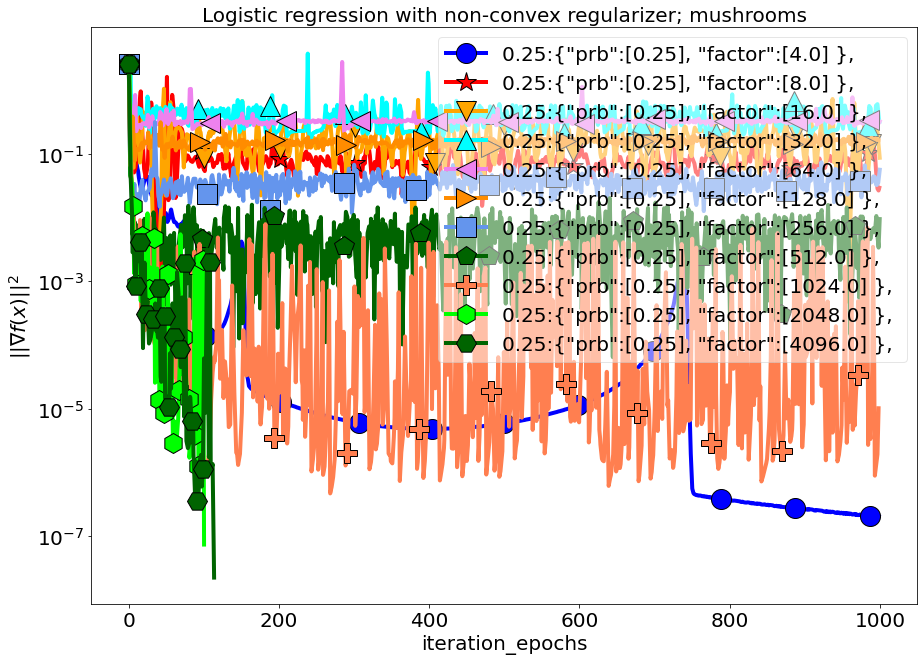

0.125:{"prb":[0.125], "factor":[4.0] },  iter:      452; norms:  9.71e-08  bits/n:      678
0.125:{"prb":[0.125], "factor":[8.0] },  iter:      679; norms:  7.15e-02  bits/n:      998
0.125:{"prb":[0.125], "factor":[16.0] },  iter:      659; norms:  7.59e-02  bits/n:      998
0.125:{"prb":[0.125], "factor":[32.0] },  iter:      670; norms:  3.13e-01  bits/n:      999
0.125:{"prb":[0.125], "factor":[64.0] },  iter:      678; norms:  3.18e-01  bits/n:      998
0.125:{"prb":[0.125], "factor":[128.0] },  iter:      668; norms:  1.18e-01  bits/n:      999
0.125:{"prb":[0.125], "factor":[256.0] },  iter:      668; norms:  2.95e-02  bits/n:      999
0.125:{"prb":[0.125], "factor":[512.0] },  iter:      674; norms:  1.35e-02  bits/n:      999
0.125:{"prb":[0.125], "factor":[1024.0] },  iter:      673; norms:  1.76e-05  bits/n:      998
0.125:{"prb":[0.125], "factor":[2048.0] },  iter:      146; norms:  1.08e-08  bits/n:      209
0.125:{"prb":[0.125], "factor":[4096.0] },  iter:       63; norms

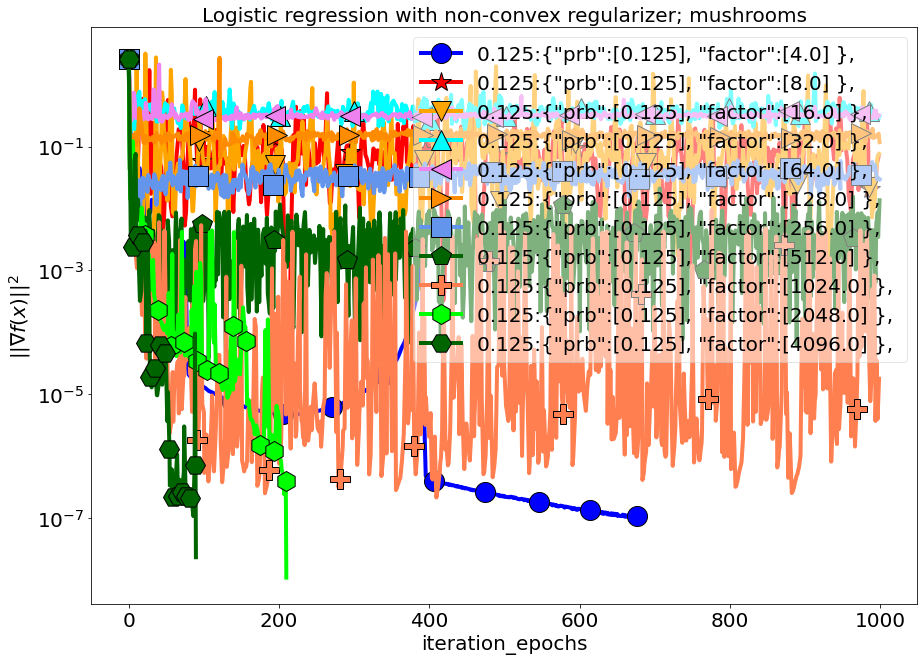

w8a
0.25:{"prb":[0.25], "factor":[4.0] },  iter:       23; norms:  2.57e-10  bits/n:       34
0.25:{"prb":[0.25], "factor":[8.0] },  iter:      665; norms:  4.18e-01  bits/n:      998
0.25:{"prb":[0.25], "factor":[16.0] },  iter:      650; norms:  1.04e+00  bits/n:      999
0.25:{"prb":[0.25], "factor":[32.0] },  iter:      672; norms:  5.48e-01  bits/n:      998
0.25:{"prb":[0.25], "factor":[64.0] },  iter:      652; norms:  1.81e-01  bits/n:      997
0.25:{"prb":[0.25], "factor":[128.0] },  iter:      653; norms:  3.77e-02  bits/n:      998
0.25:{"prb":[0.25], "factor":[256.0] },  iter:      661; norms:  1.41e-02  bits/n:      999
0.25:{"prb":[0.25], "factor":[512.0] },  iter:      666; norms:  5.30e-03  bits/n:      999
0.25:{"prb":[0.25], "factor":[1024.0] },  iter:      656; norms:  4.35e-03  bits/n:      998
0.25:{"prb":[0.25], "factor":[2048.0] },  iter:      677; norms:  5.01e-03  bits/n:      999
0.25:{"prb":[0.25], "factor":[4096.0] },  iter:      660; norms:  6.92e-05  bits/

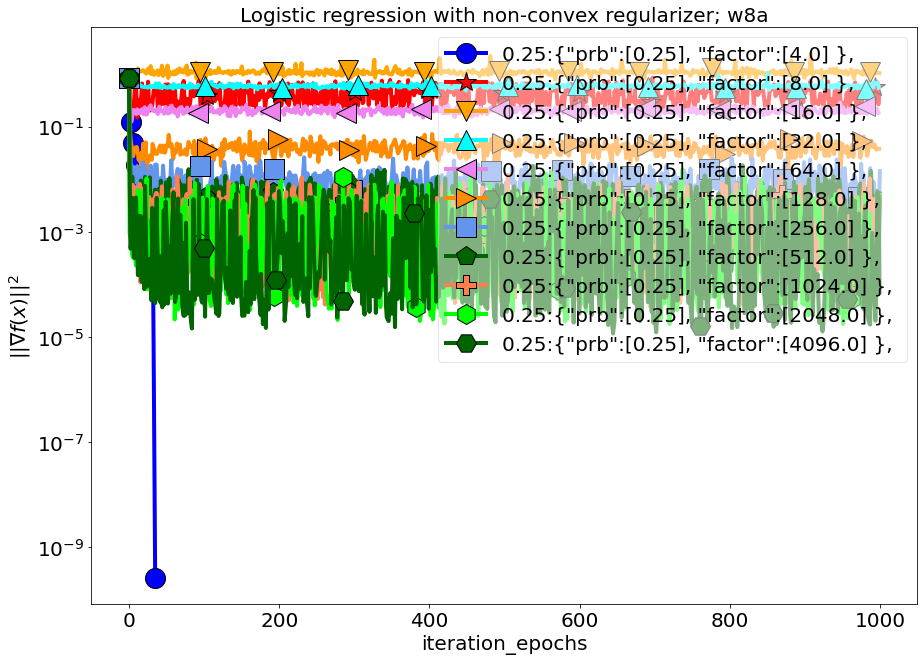

0.125:{"prb":[0.125], "factor":[4.0] },  iter:       16; norms:  2.85e-09  bits/n:       20
0.125:{"prb":[0.125], "factor":[8.0] },  iter:      672; norms:  4.10e-01  bits/n:      998
0.125:{"prb":[0.125], "factor":[16.0] },  iter:      661; norms:  1.28e+00  bits/n:      998
0.125:{"prb":[0.125], "factor":[32.0] },  iter:      674; norms:  5.30e-01  bits/n:      998
0.125:{"prb":[0.125], "factor":[64.0] },  iter:      677; norms:  1.86e-01  bits/n:      998
0.125:{"prb":[0.125], "factor":[128.0] },  iter:      669; norms:  2.68e-02  bits/n:      999
0.125:{"prb":[0.125], "factor":[256.0] },  iter:      666; norms:  9.43e-03  bits/n:      998
0.125:{"prb":[0.125], "factor":[512.0] },  iter:      667; norms:  1.31e-04  bits/n:      999
0.125:{"prb":[0.125], "factor":[1024.0] },  iter:      668; norms:  3.66e-03  bits/n:      999
0.125:{"prb":[0.125], "factor":[2048.0] },  iter:      653; norms:  2.14e-04  bits/n:      999
0.125:{"prb":[0.125], "factor":[4096.0] },  iter:      650; norms

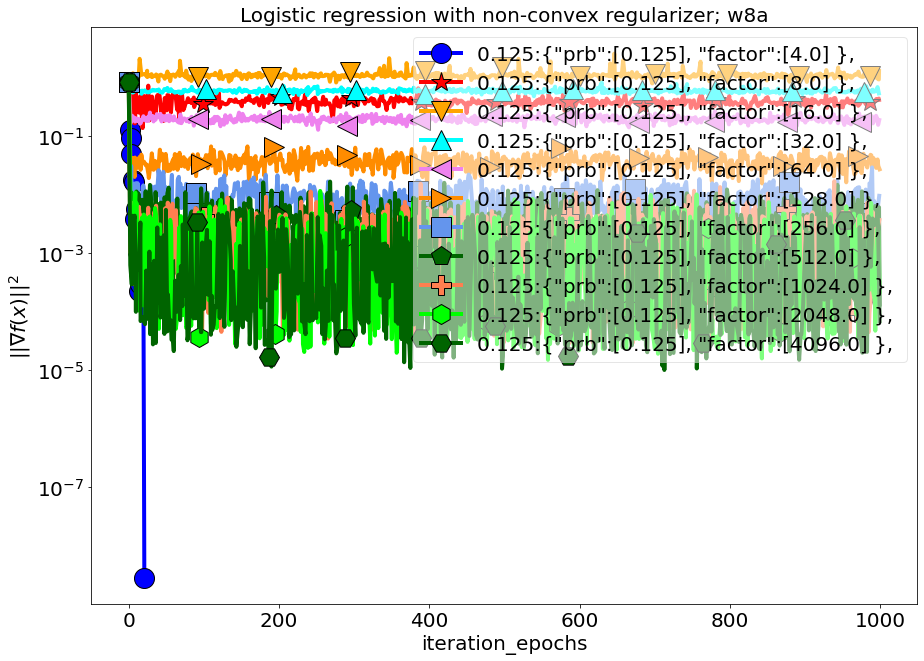

a9a
0.25:{"prb":[0.25], "factor":[4.0] },  iter:      673; norms:  1.41e-01  bits/n:      998
0.25:{"prb":[0.25], "factor":[8.0] },  iter:      664; norms:  3.80e-02  bits/n:      998
0.25:{"prb":[0.25], "factor":[16.0] },  iter:      651; norms:  2.66e-01  bits/n:      999
0.25:{"prb":[0.25], "factor":[32.0] },  iter:      670; norms:  1.02e+00  bits/n:      999
0.25:{"prb":[0.25], "factor":[64.0] },  iter:      649; norms:  2.65e-01  bits/n:      999
0.25:{"prb":[0.25], "factor":[128.0] },  iter:      673; norms:  2.95e-01  bits/n:      999
0.25:{"prb":[0.25], "factor":[256.0] },  iter:      666; norms:  2.85e-01  bits/n:      999
0.25:{"prb":[0.25], "factor":[512.0] },  iter:      654; norms:  2.62e-01  bits/n:      998
0.25:{"prb":[0.25], "factor":[1024.0] },  iter:      666; norms:  2.27e-01  bits/n:      999
0.25:{"prb":[0.25], "factor":[2048.0] },  iter:      650; norms:  2.77e-01  bits/n:      999
0.25:{"prb":[0.25], "factor":[4096.0] },  iter:      670; norms:  2.14e-01  bits/

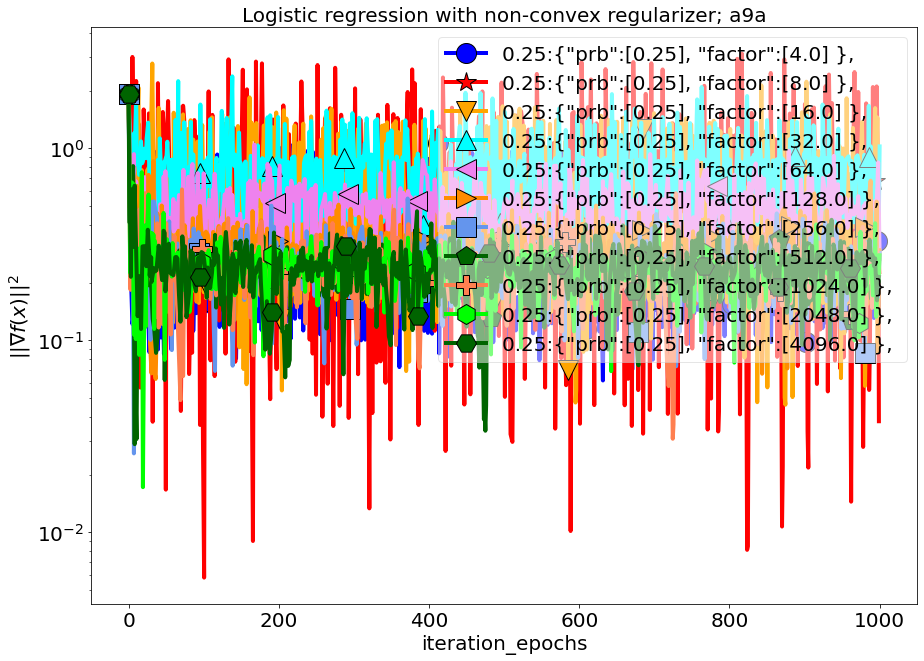

0.125:{"prb":[0.125], "factor":[4.0] },  iter:      659; norms:  4.43e-01  bits/n:      999
0.125:{"prb":[0.125], "factor":[8.0] },  iter:      659; norms:  7.21e-01  bits/n:      999
0.125:{"prb":[0.125], "factor":[16.0] },  iter:      662; norms:  7.37e-01  bits/n:      999
0.125:{"prb":[0.125], "factor":[32.0] },  iter:      687; norms:  4.36e-01  bits/n:      998
0.125:{"prb":[0.125], "factor":[64.0] },  iter:      664; norms:  5.15e-01  bits/n:      999
0.125:{"prb":[0.125], "factor":[128.0] },  iter:      670; norms:  1.49e-01  bits/n:      999
0.125:{"prb":[0.125], "factor":[256.0] },  iter:      676; norms:  2.51e-01  bits/n:      998
0.125:{"prb":[0.125], "factor":[512.0] },  iter:      648; norms:  3.05e-01  bits/n:      997
0.125:{"prb":[0.125], "factor":[1024.0] },  iter:      676; norms:  4.98e-02  bits/n:      998
0.125:{"prb":[0.125], "factor":[2048.0] },  iter:      660; norms:  2.69e-01  bits/n:      999
0.125:{"prb":[0.125], "factor":[4096.0] },  iter:      661; norms

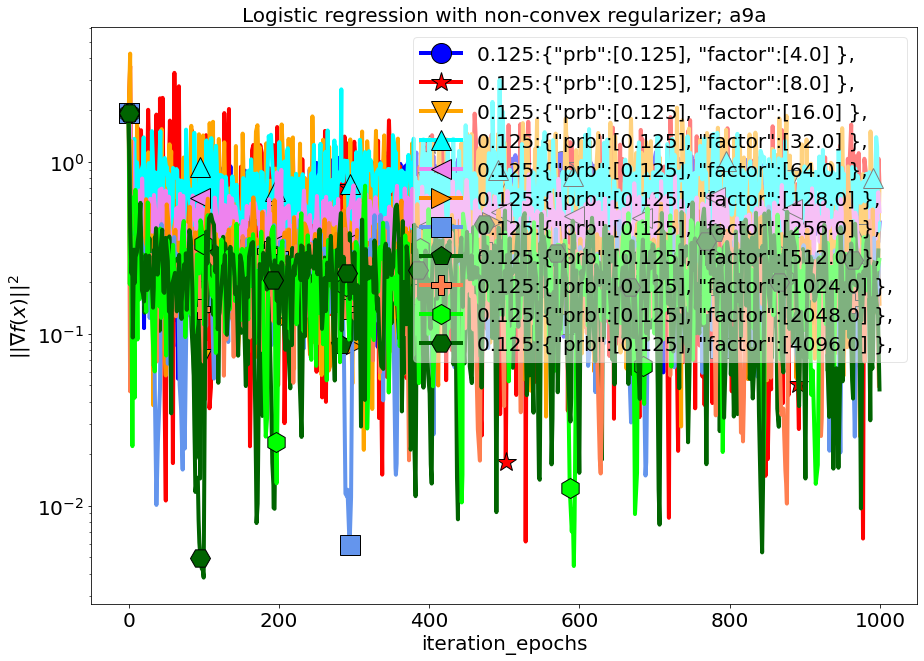

phishing
0.25:{"prb":[0.25], "factor":[4.0] },  iter:      659; norms:  5.72e-01  bits/n:      999
0.25:{"prb":[0.25], "factor":[8.0] },  iter:      669; norms:  2.00e-01  bits/n:      998
0.25:{"prb":[0.25], "factor":[16.0] },  iter:      675; norms:  1.13e-01  bits/n:      999
0.25:{"prb":[0.25], "factor":[32.0] },  iter:      672; norms:  4.00e-02  bits/n:      998
0.25:{"prb":[0.25], "factor":[64.0] },  iter:      673; norms:  1.80e-03  bits/n:      998
0.25:{"prb":[0.25], "factor":[128.0] },  iter:      665; norms:  5.37e-03  bits/n:      998
0.25:{"prb":[0.25], "factor":[256.0] },  iter:      670; norms:  1.47e-02  bits/n:      999
0.25:{"prb":[0.25], "factor":[512.0] },  iter:      664; norms:  1.02e-04  bits/n:      999
0.25:{"prb":[0.25], "factor":[1024.0] },  iter:      670; norms:  3.01e-03  bits/n:      999
0.25:{"prb":[0.25], "factor":[2048.0] },  iter:      667; norms:  2.21e-03  bits/n:      999
0.25:{"prb":[0.25], "factor":[4096.0] },  iter:      659; norms:  5.68e-05  

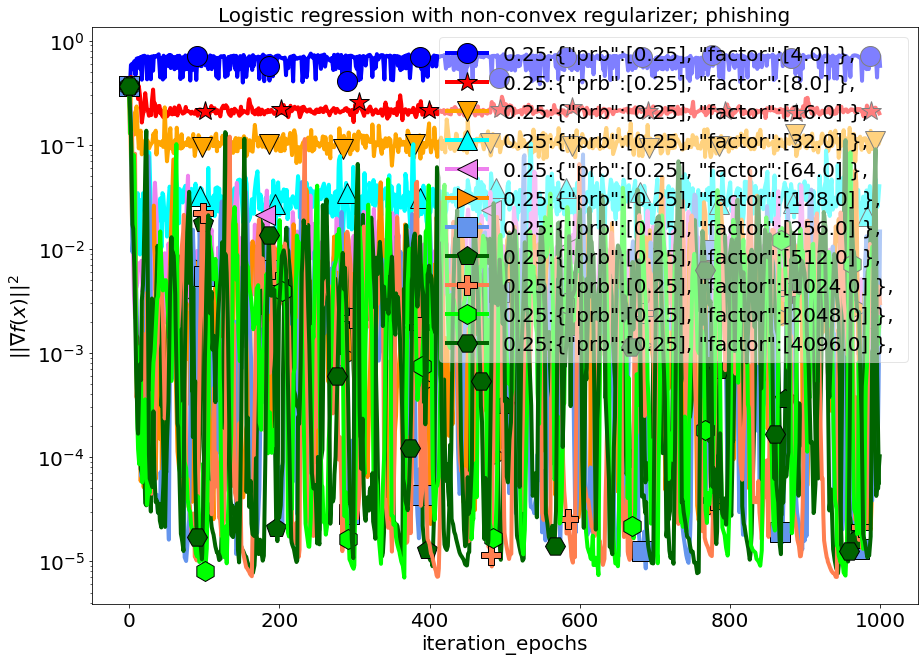

0.125:{"prb":[0.125], "factor":[4.0] },  iter:      659; norms:  4.02e-01  bits/n:      999
0.125:{"prb":[0.125], "factor":[8.0] },  iter:      664; norms:  2.05e-01  bits/n:      998
0.125:{"prb":[0.125], "factor":[16.0] },  iter:      659; norms:  7.87e-02  bits/n:      999
0.125:{"prb":[0.125], "factor":[32.0] },  iter:      666; norms:  3.50e-02  bits/n:      998
0.125:{"prb":[0.125], "factor":[64.0] },  iter:      672; norms:  8.95e-03  bits/n:      998
0.125:{"prb":[0.125], "factor":[128.0] },  iter:      687; norms:  2.27e-04  bits/n:      999
0.125:{"prb":[0.125], "factor":[256.0] },  iter:      657; norms:  1.42e-04  bits/n:      999
0.125:{"prb":[0.125], "factor":[512.0] },  iter:      673; norms:  1.20e-03  bits/n:      999
0.125:{"prb":[0.125], "factor":[1024.0] },  iter:      655; norms:  3.03e-04  bits/n:      998
0.125:{"prb":[0.125], "factor":[2048.0] },  iter:      675; norms:  6.36e-05  bits/n:      998
0.125:{"prb":[0.125], "factor":[4096.0] },  iter:      667; norms

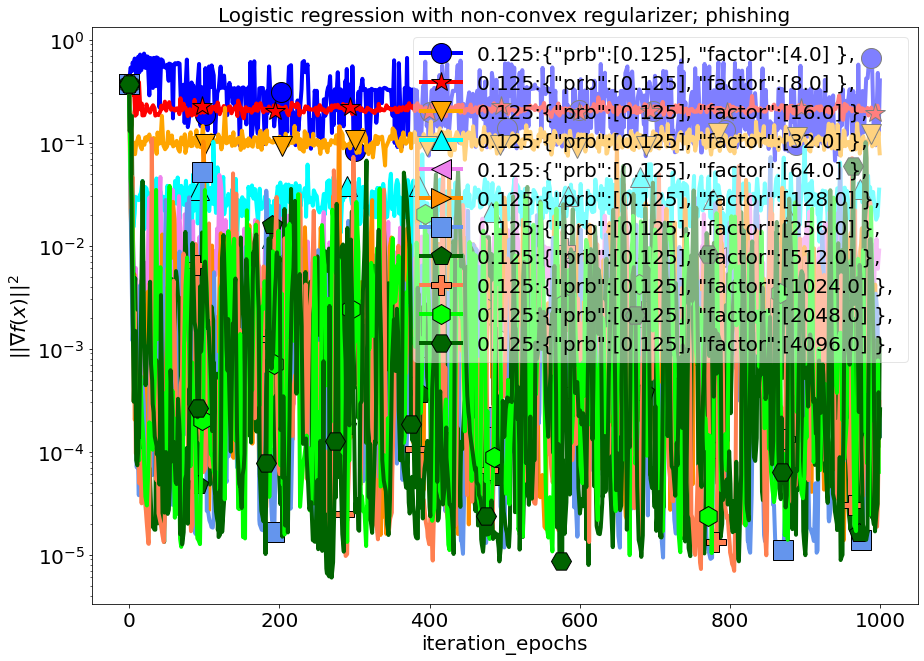

In [156]:
project_path = os.getcwd() + "/"

dataset_ar = ['mushrooms', 'w8a', 'a9a', 'phishing']
#dataset_ar = ['mushrooms']
#ataset_ar = ['w8a']
#dataset_ar = ['a9a']
#dataset_ar = ['phishing']
#dataset_ar = ['realsim']
exps = ["page"]
main_title = "comparison_best"

draw = 1          #draw or not
save = 0           #save or not pdf of each plot 
save_separately = 0
print_each_exp = 1
dict_type_output = 1

cut_axis = 1

myrepr = lambda x: repr(round(x, 4)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding
#myrepr = lambda x: repr(round(x, 2)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding

n_ar = [20]
page_prb_ar_ar = [[0.25], [0.125]]

for dataset in dataset_ar:
    print(dataset)
    for page_prb_ar in page_prb_ar_ar:
        data_path = project_path + "data_{0}/".format(dataset)
        if save_separately:
            plot_path = project_path + "plot_{0}/".format(dataset)
        else:
            plot_path = project_path + "plot_all-datasets/"
        
        page_factor_ar = np.array([4,8,16,32,64,128,256,512,1024,2048,4096], dtype=float)

        if cut_axis:
            ub_x = {'iteration_bits_od':{'mushrooms':300_000, 'w8a':300_000, 'a9a':100_000, 'phishing':50000, 'realsim':300_000},
               'iteration_epochs':{'mushrooms':1000, 'w8a':1000, 'a9a':1000, 'phishing':1000, 'realsim':1000}}[x_axis][dataset]
        else:
            ub_x = 1e+20
        
        y_axis = 'norms' 
        x_axis = 'iteration_bits_od'
        #x_axis = 'iteration_bits_bd'
        x_axis = 'iteration_epochs'
        #x_axis = 'iteration_comm'

        its_ar = []
        norms_ar= []
        label_ar = []

        exp_page_ar = []
        label_page_ar = []


        if "page" in exps:
            exp_page_ar = ["page_nw-{0}_{1}x_{2}".format(n, myrepr(page_factor), myrepr(prb)) for n, page_factor, prb in itertools.product(n_ar, page_factor_ar,page_prb_ar)]
            if dict_type_output:
                label_page_ar = [f"{prb}:{{\"prb\":[{prb}], \"factor\":[{page_factor}] }}, " for page_factor,prb in itertools.product(page_factor_ar,page_prb_ar)]
            else:
                label_page_ar = ["PAGE; {0}x; {1}".format(page_factor, prb) for page_factor,prb in itertools.product(page_factor_ar,page_prb_ar)]

        experiment_ar = exp_page_ar
        label_ar = label_page_ar 

        its_last_value = np.zeros(len(experiment_ar))
        norms_last_value = np.zeros(len(experiment_ar))

        tol = 1e-0
        for i, experiment in enumerate(experiment_ar):
            logs_path = project_path + "logs/logs_{0}_{1}/".format(dataset, experiment)
            logs_file_its = logs_path + x_axis + "_" + experiment + ".npy"    
            if os.path.isfile(logs_file_its):
                its = np.load(logs_file_its)
                if len (its.shape)==2:
                    if its.shape[0] ==1:
                        its = its.flatten()
                    else: 
                        raise ValueError("wrong shape")            
                its_comm  = np.arange(its.shape[0])
                number_its = len(its[its < ub_x])
                its_ar.append(its[:number_its])
                norms = np.load(logs_path + y_axis + '_' + experiment+'.npy')
                if len (norms.shape)==2:
                    if norms.shape[0]==1:
                        norms = norms.flatten()
                    else: 
                        raise ValueError("wrong shape")
                norms_ar.append(norms[:number_its])
                norms_last_value[i] = norms_ar[-1][-1]
                if norms_last_value[i] > tol:
                    its_last_value[i] = np.inf
                else:
                    its_last_value[i] = its_ar[-1][-1]
            else:
                its_ar.append(np.array([-1])) #emplhasising the error
                norms_ar.append(np.array([-1]))
                its_last_value[i] = np.inf #to exclude it from minimization
                norms_last_value[i] = np.inf
                print (logs_path +" "+ experiment+" is not computed")

            if print_each_exp:
                print ("%34s iter: %8d; norms: %9.2e  bits/n: %8d"%(label_ar[i], its_ar[-1].shape[0], norms_ar[-1][-1], its_ar[-1][-1]) )        
        inf_inds = np.argwhere(np.isinf(norms_last_value)).flatten()
        nan_inds = np.argwhere(np.isnan(norms_last_value)).flatten()
        its_last_value[nan_inds] = np.inf
        its_last_value[inf_inds] = np.inf
        #it_min = np.argmin (its_last_value)
        it_min = np.argmin (norms_last_value)
        if dict_type_output:
            print (label_ar[it_min])
        else:
            print ("\n %34s iter: %8d; norms: %9.2e  bits/n: %8d \n"%(label_ar[it_min], its_ar[it_min].shape[0], norms_ar[it_min][-1], its_last_value[it_min]))
        filename = "{0}_{1}.pdf".format(main_title, dataset)
        if draw:
            plot1(its_ar, norms_ar, label_ar, plot_path, dataset, filename=filename, save=save, xaxis=x_axis)

## EF21-PAGE

In [57]:
project_path = os.getcwd() + "/"

dataset_ar = ['mushrooms', 'w8a', 'a9a', 'phishing']
dataset_ar = ['realsim']

exps = ["ef21_page"]
main_title = "comparison_best"

draw = 0          #draw or not
save = 0           #save or not pdf of each plot 
save_separately = 0
print_each_exp = 0

dict_type_output = 0
    
myrepr = lambda x: repr(round(x, 4)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding
#myrepr = lambda x: repr(round(x, 2)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding

n_ar = [20]
ef21_page_prb_ar_ar = [[0.5],[0.25],[0.125],[0.015],[0.007] ]
ef21_page_prb_ar_ar = [[0.25], [0.125], [0.015]]

for dataset in dataset_ar:
    print(dataset)
    for ef21_page_prb_ar in ef21_page_prb_ar_ar:
        data_path = project_path + "data_{0}/".format(dataset)
        if save_separately:
            plot_path = project_path + "plot_{0}/".format(dataset)
        else:
            plot_path = project_path + "plot_all-datasets/"

        ef21_page_k_ar = {'mushrooms':[2], 'w8a':[2], 'a9a':[2], 'phishing':[1], 'realsim':[210]}[dataset]
        ef21_page_factor_ar = np.array([4,8,16,32,64,128,256,512,1024,2048,4096], dtype=float)

        y_axis = 'norms'
        x_axis = 'iteration_bits_od'
        #x_axis = 'iteration_bits_bd'
        #x_axis = 'iteration_epochs'
        #x_axis = 'iteration_comm'

        its_ar = []
        norms_ar= []
        label_ar = []

        exp_ef21_page_ar = []
        label_ef21_page_ar = []

        
        if "ef21_page" in exps:
            exp_ef21_page_ar = ["ef21-page_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_page_factor), myrepr(prb), k) for n, k, ef21_page_factor, prb in itertools.product(n_ar, ef21_page_k_ar, ef21_page_factor_ar,ef21_page_prb_ar)]
            if dict_type_output:
                label_ef21_page_ar = [f"{prb}:{{\"k\":[{k}],\"prb\":[{prb}], \"factor\":[{ef21_page_factor}] }}, " for n, k, ef21_page_factor,prb in itertools.product(n_ar, ef21_page_k_ar, ef21_page_factor_ar,ef21_page_prb_ar)]
            else:
                label_ef21_page_ar = ["PAGE-EF21; Top-{0}; {1}x; {2}".format(k, ef21_page_factor, prb) for n, k, ef21_page_factor,prb in itertools.product(n_ar, ef21_page_k_ar, ef21_page_factor_ar,ef21_page_prb_ar)]


        experiment_ar = exp_ef21_page_ar 
        label_ar = label_ef21_page_ar 
        
        its_last_value = np.zeros(len(experiment_ar))
        norms_last_value = np.zeros(len(experiment_ar))

        tol = 1e-1
        for i, experiment in enumerate(experiment_ar):
            logs_path = project_path + "logs/logs_{0}_{1}/".format(dataset, experiment)
            logs_file_its = logs_path + x_axis + "_" + experiment + ".npy"    
            if os.path.isfile(logs_file_its):
                its = np.load(logs_file_its)
                if len (its.shape)==2:
                    if its.shape[0] ==1:
                        its = its.flatten()
                    else: 
                        raise ValueError("wrong shape")            
                its_comm  = np.arange(its.shape[0])
                its_ar.append(its)
                norms = np.load(logs_path + y_axis + '_' + experiment+'.npy')
                if len (norms.shape)==2:
                    if norms.shape[0]==1:
                        norms = norms.flatten()
                    else: 
                        raise ValueError("wrong shape")
                norms_ar.append(norms)
                norms_last_value[i] = norms_ar[-1][-1]
                if norms_last_value[i] > tol:
                    its_last_value[i] = np.inf
                else:
                    its_last_value[i] = its_ar[-1][-1]
            else:
                its_ar.append(np.array([-1])) #emplhasising the error
                norms_ar.append(np.array([-1]))
                its_last_value[i] = np.inf #to exclude it from minimization
                norms_last_value[i] = np.inf
                print (logs_path +" "+ experiment+" is not computed")

            if print_each_exp:
                print ("%34s iter: %8d; norms: %9.2e  bits/n: %8d"%(label_ar[i], its_ar[-1].shape[0], norms_ar[-1][-1], its_ar[-1][-1]) )        
        inf_inds = np.argwhere(np.isinf(norms_last_value)).flatten()
        nan_inds = np.argwhere(np.isnan(norms_last_value)).flatten()
        its_last_value[nan_inds] = np.inf
        its_last_value[inf_inds] = np.inf
        it_min = np.argmin (its_last_value)
        #it_min = np.argmin (norms_last_value)
        if dict_type_output:
            print (label_ar[it_min])
        else:
            print ("prb = ", ef21_page_prb_ar[0]," MIN: %34s iter: %8d; norms: %9.2e  bits/n: %8d"%(label_ar[it_min], its_ar[it_min].shape[0], norms_ar[it_min][-1], its_last_value[it_min]))
        #print ("Num exps: ",len(label_ar))
        filename = "{0}_{1}.pdf".format(main_title, dataset)
        if draw:
            plot1(its_ar, norms_ar, label_ar, plot_path, dataset, filename=filename, save=save)

realsim
prb =  0.25  MIN:    PAGE-EF21; Top-210; 32.0x; 0.25 iter:      803; norms:  3.51e-02  bits/n: 13440000
prb =  0.125  MIN:    PAGE-EF21; Top-210; 8.0x; 0.125 iter:      724; norms:  9.63e-08  bits/n: 22505280
prb =  0.015  MIN:    PAGE-EF21; Top-210; 8.0x; 0.015 iter:      101; norms:  8.51e-09  bits/n: 22619520


## EF21-PP

realsim
0.5:{"k":[210],"prw":[0.5], "factor":[4.0] },  iter:      298; norms:  9.06e+00  bits/n:   997920
0.5:{"k":[210],"prw":[0.5], "factor":[8.0] },  iter:      298; norms:  6.27e+00  bits/n:   997920
0.5:{"k":[210],"prw":[0.5], "factor":[16.0] },  iter:      298; norms:  2.98e+00  bits/n:   997920
0.5:{"k":[210],"prw":[0.5], "factor":[32.0] },  iter:      298; norms:  1.12e+00  bits/n:   997920
0.5:{"k":[210],"prw":[0.5], "factor":[64.0] },  iter:      298; norms:  1.57e-01  bits/n:   997920
0.5:{"k":[210],"prw":[0.5], "factor":[128.0] },  iter:      298; norms:  1.81e-02  bits/n:   997920
0.5:{"k":[210],"prw":[0.5], "factor":[256.0] },  iter:      298; norms:  6.06e-04  bits/n:   997920
0.5:{"k":[210],"prw":[0.5], "factor":[512.0] },  iter:      298; norms:  5.81e-04  bits/n:   997920
0.5:{"k":[210],"prw":[0.5], "factor":[1024.0] },  iter:      298; norms:  1.03e-01  bits/n:   997920
0.5:{"k":[210],"prw":[0.5], "factor":[512.0] }, 


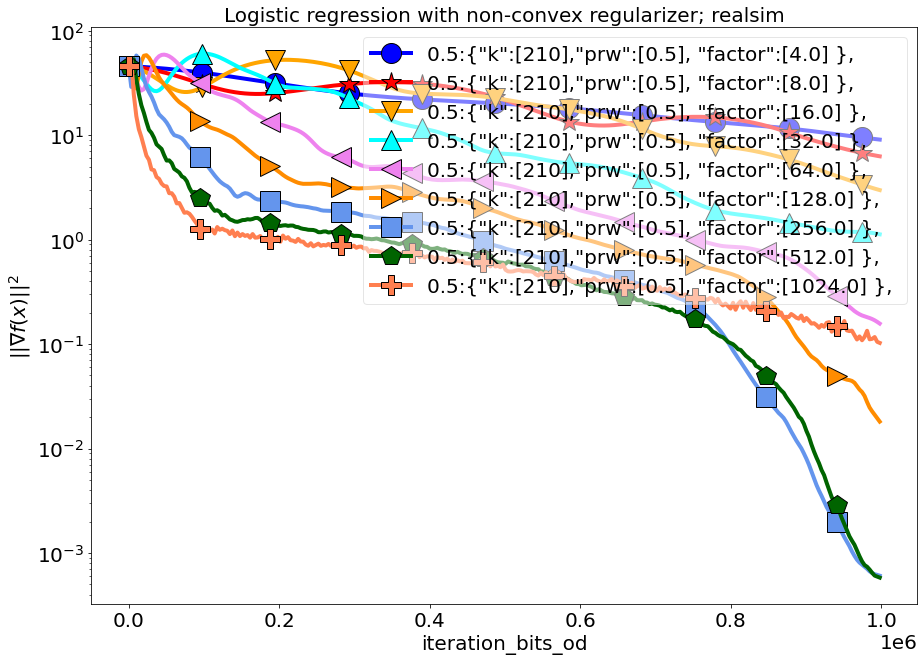

0.25:{"k":[210],"prw":[0.25], "factor":[4.0] },  iter:      596; norms:  5.76e+00  bits/n:   999600
0.25:{"k":[210],"prw":[0.25], "factor":[8.0] },  iter:      596; norms:  3.89e+00  bits/n:   999600
0.25:{"k":[210],"prw":[0.25], "factor":[16.0] },  iter:      596; norms:  9.36e-01  bits/n:   999600
0.25:{"k":[210],"prw":[0.25], "factor":[32.0] },  iter:      596; norms:  1.54e-01  bits/n:   999600
0.25:{"k":[210],"prw":[0.25], "factor":[64.0] },  iter:      596; norms:  1.20e-02  bits/n:   999600
0.25:{"k":[210],"prw":[0.25], "factor":[128.0] },  iter:      596; norms:  5.61e-04  bits/n:   999600
0.25:{"k":[210],"prw":[0.25], "factor":[256.0] },  iter:      596; norms:  4.70e-04  bits/n:   999600
0.25:{"k":[210],"prw":[0.25], "factor":[512.0] },  iter:      596; norms:  5.25e-04  bits/n:   999600
0.25:{"k":[210],"prw":[0.25], "factor":[1024.0] },  iter:      596; norms:  2.95e-03  bits/n:   999600
0.25:{"k":[210],"prw":[0.25], "factor":[256.0] }, 


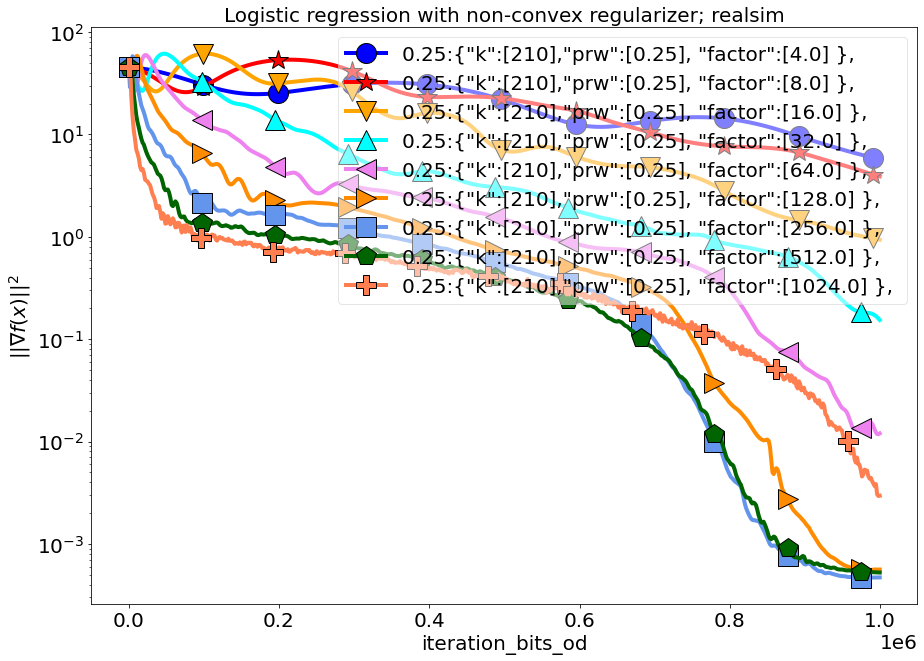

0.125:{"k":[210],"prw":[0.125], "factor":[4.0] },  iter:     1241; norms:  3.16e+00  bits/n:   999936
0.125:{"k":[210],"prw":[0.125], "factor":[8.0] },  iter:     1241; norms:  8.60e-01  bits/n:   999936
0.125:{"k":[210],"prw":[0.125], "factor":[16.0] },  iter:     1241; norms:  1.17e-01  bits/n:   999936
0.125:{"k":[210],"prw":[0.125], "factor":[32.0] },  iter:     1241; norms:  5.32e-03  bits/n:   999936
0.125:{"k":[210],"prw":[0.125], "factor":[64.0] },  iter:     1241; norms:  7.32e-03  bits/n:   999936
0.125:{"k":[210],"prw":[0.125], "factor":[128.0] },  iter:     1241; norms:  2.66e-04  bits/n:   999936
0.125:{"k":[210],"prw":[0.125], "factor":[256.0] },  iter:     1241; norms:  4.87e-04  bits/n:   999936
0.125:{"k":[210],"prw":[0.125], "factor":[512.0] },  iter:     1241; norms:  6.12e-04  bits/n:   999936
0.125:{"k":[210],"prw":[0.125], "factor":[1024.0] },  iter:     1241; norms:  7.77e-03  bits/n:   999936
0.125:{"k":[210],"prw":[0.125], "factor":[128.0] }, 


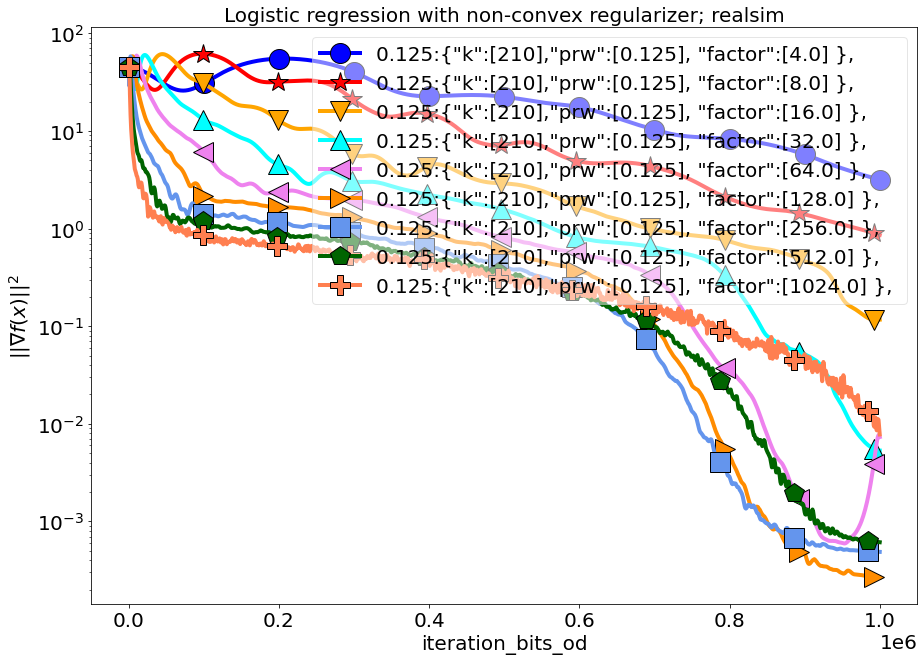

0.065:{"k":[210],"prw":[0.065], "factor":[4.0] },  iter:     2481; norms:  8.50e-01  bits/n:   999936
0.065:{"k":[210],"prw":[0.065], "factor":[8.0] },  iter:     2481; norms:  1.29e-01  bits/n:   999936
0.065:{"k":[210],"prw":[0.065], "factor":[16.0] },  iter:     2481; norms:  5.42e-03  bits/n:   999936
0.065:{"k":[210],"prw":[0.065], "factor":[32.0] },  iter:     2481; norms:  7.64e-04  bits/n:   999936
0.065:{"k":[210],"prw":[0.065], "factor":[64.0] },  iter:     2481; norms:  2.88e-04  bits/n:   999936
0.065:{"k":[210],"prw":[0.065], "factor":[128.0] },  iter:     2481; norms:  4.72e-04  bits/n:   999936
0.065:{"k":[210],"prw":[0.065], "factor":[256.0] },  iter:     2481; norms:  5.90e-04  bits/n:   999936
0.065:{"k":[210],"prw":[0.065], "factor":[512.0] },  iter:     2481; norms:  1.30e-03  bits/n:   999936
0.065:{"k":[210],"prw":[0.065], "factor":[1024.0] },  iter:     2481; norms:  1.38e-01  bits/n:   999936
0.065:{"k":[210],"prw":[0.065], "factor":[64.0] }, 


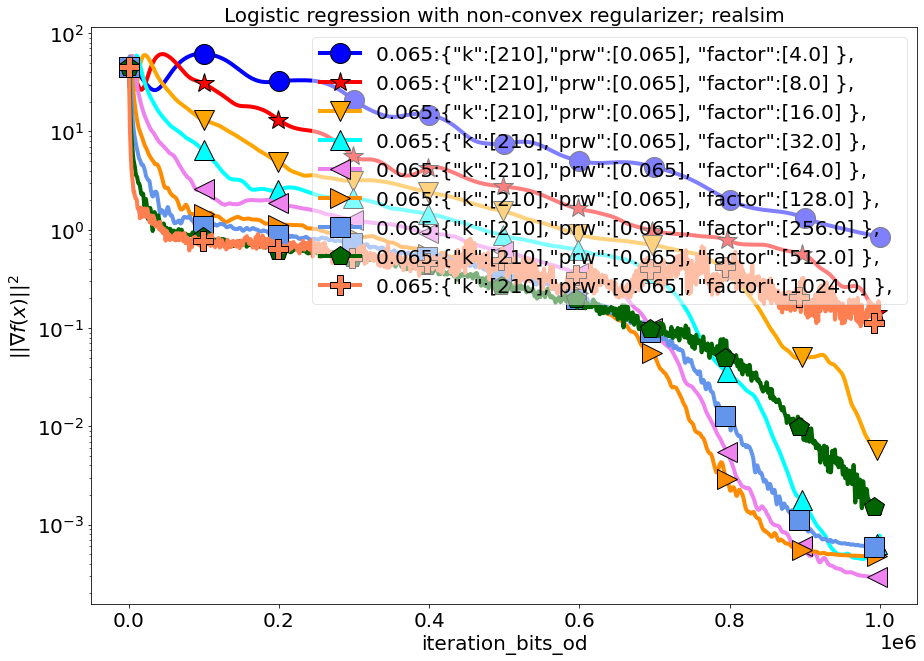

In [111]:
project_path = os.getcwd() + "/"

dataset_ar = ['mushrooms', 'w8a', 'a9a', 'phishing']
dataset_ar = ['realsim']

exps = ["ef21_pp"]
main_title = "comparison_best"

draw = 1          #draw or not
save = 0           #save or not pdf of each plot 
save_separately = 0
print_each_exp = 1

if "ef21_pp" in exps:
    n_ar = [100]
else:
    n_ar = [20]
dict_type_output = 1
    
myrepr = lambda x: repr(round(x, 4)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding
#myrepr = lambda x: repr(round(x, 2)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding

ef21_pp_prw_ar_ar = [[0.5],[0.25],[0.125],[0.065]]

for dataset in dataset_ar:
    print(dataset)
    for ef21_pp_prw_ar in ef21_pp_prw_ar_ar:
        data_path = project_path + "data_{0}/".format(dataset)
        if save_separately:
            plot_path = project_path + "plot_{0}/".format(dataset)
        else:
            plot_path = project_path + "plot_all-datasets/"

        ##################
        ## EF21 with PP ##
        ##################
        ef21_pp_k_ar = {'mushrooms':[2], 'w8a':[2], 'a9a':[2], 'phishing':[1], 'realsim':[210]}[dataset]
        ef21_pp_factor_ar = np.array([4,8,16,32,64,128,256,512,1024], dtype=float)
        

        y_axis = 'norms'
        x_axis = 'iteration_bits_od'
        #x_axis = 'iteration_bits_bd'
        #x_axis = 'iteration_epochs'
        #x_axis = 'iteration_comm'

        its_ar = []
        norms_ar= []
        label_ar = []

        exp_ef21_pp_ar = []
        label_ef21_pp_ar = []



        if "ef21_pp" in exps:
            exp_ef21_pp_ar = ["ef21-pp_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_pp_factor), myrepr(prw), k) for n, k, ef21_pp_factor, prw in itertools.product(n_ar, ef21_pp_k_ar, ef21_pp_factor_ar,ef21_pp_prw_ar)]
            if dict_type_output:
                label_ef21_pp_ar = [f"{prw}:{{\"k\":[{k}],\"prw\":[{prw}], \"factor\":[{ef21_pp_factor}] }}, " for n, k, ef21_pp_factor,prw in itertools.product(n_ar, ef21_pp_k_ar, ef21_pp_factor_ar,ef21_pp_prw_ar)]
            else:
                label_ef21_pp_ar = ["PP-EF21; Top-{0}; {1}x; {2}".format(k, ef21_pp_factor, prw) for n, k, ef21_pp_factor,prw in itertools.product(n_ar, ef21_pp_k_ar, ef21_pp_factor_ar,ef21_pp_prw_ar)]


        experiment_ar =  exp_ef21_pp_ar 
        label_ar =  label_ef21_pp_ar 

        its_last_value = np.zeros(len(experiment_ar))
        norms_last_value = np.zeros(len(experiment_ar))

        if cut_axis:
            ub_x = {'iteration_bits_od':{'mushrooms':300_000, 'w8a':300_000, 'a9a':100_000, 'phishing':50000, 'realsim':1_000_000},
               'iteration_epochs':{'mushrooms':1000, 'w8a':1000, 'a9a':1000, 'phishing':1000, 'realsim':1000}}[x_axis][dataset]
        else:
            ub_x = 1e+20
        tol = 1e-0
        for i, experiment in enumerate(experiment_ar):
            logs_path = project_path + "logs/logs_{0}_{1}/".format(dataset, experiment)
            logs_file_its = logs_path + x_axis + "_" + experiment + ".npy"    
            if os.path.isfile(logs_file_its):
                its = np.load(logs_file_its)
                if len (its.shape)==2:
                    if its.shape[0] ==1:
                        its = its.flatten()
                    else: 
                        raise ValueError("wrong shape")            
                its_comm  = np.arange(its.shape[0])
                number_its = len(its[its < ub_x])
                its_ar.append(its[:number_its])
                norms = np.load(logs_path + y_axis + '_' + experiment+'.npy')
                if len (norms.shape)==2:
                    if norms.shape[0]==1:
                        norms = norms.flatten()
                    else: 
                        raise ValueError("wrong shape")
                norms_ar.append(norms[:number_its])
                norms_last_value[i] = norms_ar[-1][-1]
                if norms_last_value[i] > tol:
                    its_last_value[i] = np.inf
                else:
                    its_last_value[i] = its_ar[-1][-1]
            else:
                its_ar.append(np.array([-1])) #emplhasising the error
                norms_ar.append(np.array([-1]))
                its_last_value[i] = np.inf #to exclude it from minimization
                norms_last_value[i] = np.inf
                print (logs_path +" "+ experiment+" is not computed")

            if print_each_exp:
                print ("%34s iter: %8d; norms: %9.2e  bits/n: %8d"%(label_ar[i], its_ar[-1].shape[0], norms_ar[-1][-1], its_ar[-1][-1]) )        
        inf_inds = np.argwhere(np.isinf(norms_last_value)).flatten()
        nan_inds = np.argwhere(np.isnan(norms_last_value)).flatten()
        its_last_value[nan_inds] = np.inf
        its_last_value[inf_inds] = np.inf
        #it_min = np.argmin (its_last_value)
        it_min = np.argmin (norms_last_value)
        if dict_type_output:
            print (label_ar[it_min])
        else:
            print ("\n %34s iter: %8d; norms: %9.2e  bits/n: %8d \n"%(label_ar[it_min], its_ar[it_min].shape[0], norms_ar[it_min][-1], its_last_value[it_min]))
        filename = "{0}_{1}.pdf".format(main_title, dataset)
        if draw:
            plot1(its_ar, norms_ar, label_ar, plot_path, dataset, filename=filename, save=save, xaxis=x_axis)
            
            



## EF21-BC

realsim
210:{"k_od":[210],"k_bd":[210], "factor":[16.0] },  iter:    12001; norms:  1.52e-02  bits/n: 80640000
210:{"k_od":[210],"k_bd":[210], "factor":[32.0] },  iter:    12001; norms:  7.78e-04  bits/n: 80640000
210:{"k_od":[210],"k_bd":[210], "factor":[64.0] },  iter:    12001; norms:  1.54e+00  bits/n: 80640000
210:{"k_od":[210],"k_bd":[210], "factor":[128.0] },  iter:    13001; norms:  7.63e-01  bits/n: 87360000
210:{"k_od":[210],"k_bd":[210], "factor":[256.0] },  iter:    12001; norms:  6.45e-01  bits/n: 80640000
210:{"k_od":[210],"k_bd":[210], "factor":[512.0] },  iter:     9001; norms:  6.42e-01  bits/n: 60480000
210:{"k_od":[210],"k_bd":[210], "factor":[1024.0] },  iter:    11001; norms:  5.83e-01  bits/n: 73920000
210:{"k_od":[210],"k_bd":[210], "factor":[2048.0] },  iter:    20002; norms:  7.94e-01  bits/n: 134406720
210:{"k_od":[210],"k_bd":[210], "factor":[16.0] }, 


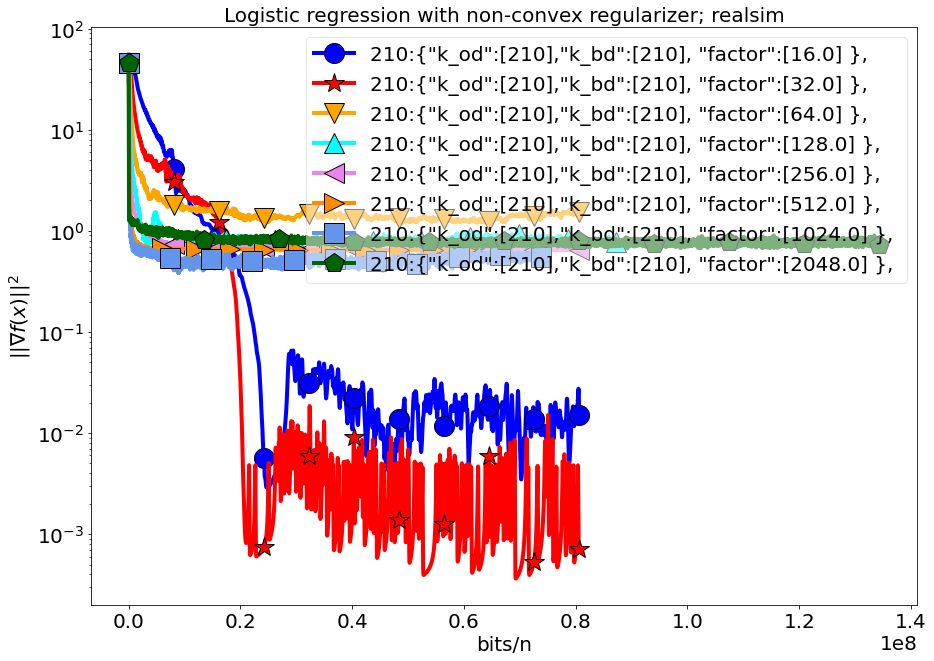

1050:{"k_od":[210],"k_bd":[1050], "factor":[16.0] },  iter:    20002; norms:  6.19e-02  bits/n: 134406720
1050:{"k_od":[210],"k_bd":[1050], "factor":[32.0] },  iter:    20002; norms:  6.93e-03  bits/n: 134406720
1050:{"k_od":[210],"k_bd":[1050], "factor":[64.0] },  iter:     1001; norms:  2.79e-02  bits/n:  6720000
1050:{"k_od":[210],"k_bd":[1050], "factor":[128.0] },  iter:    15001; norms:  5.19e-04  bits/n: 100800000
1050:{"k_od":[210],"k_bd":[1050], "factor":[256.0] },  iter:    15001; norms:  8.09e-01  bits/n: 100800000
1050:{"k_od":[210],"k_bd":[1050], "factor":[512.0] },  iter:    12001; norms:  6.48e-01  bits/n: 80640000
1050:{"k_od":[210],"k_bd":[1050], "factor":[1024.0] },  iter:    20002; norms:  5.41e-01  bits/n: 134406720
1050:{"k_od":[210],"k_bd":[1050], "factor":[2048.0] },  iter:    20002; norms:  9.41e-01  bits/n: 134406720
1050:{"k_od":[210],"k_bd":[1050], "factor":[64.0] }, 


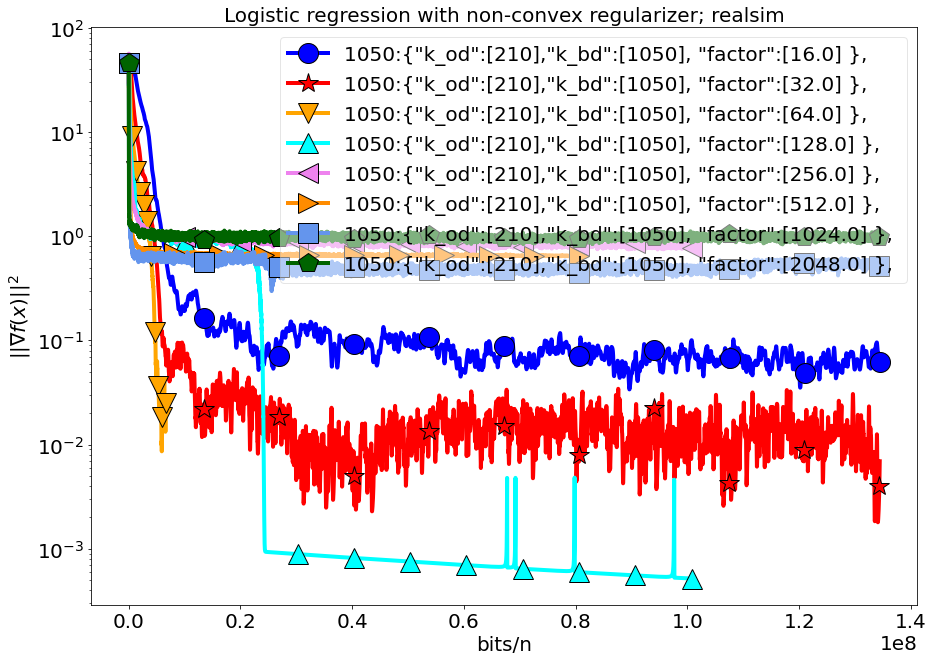

2100:{"k_od":[210],"k_bd":[2100], "factor":[16.0] },  iter:    17001; norms:  5.21e-02  bits/n: 114240000
2100:{"k_od":[210],"k_bd":[2100], "factor":[32.0] },  iter:    17001; norms:  1.01e-02  bits/n: 114240000
2100:{"k_od":[210],"k_bd":[2100], "factor":[64.0] },  iter:    16001; norms:  8.56e-04  bits/n: 107520000
2100:{"k_od":[210],"k_bd":[2100], "factor":[128.0] },  iter:    14001; norms:  5.43e-04  bits/n: 94080000
2100:{"k_od":[210],"k_bd":[2100], "factor":[256.0] },  iter:    13001; norms:  8.24e-01  bits/n: 87360000
2100:{"k_od":[210],"k_bd":[2100], "factor":[512.0] },  iter:    13001; norms:  6.46e-01  bits/n: 87360000
2100:{"k_od":[210],"k_bd":[2100], "factor":[1024.0] },  iter:    13001; norms:  5.14e-01  bits/n: 87360000
2100:{"k_od":[210],"k_bd":[2100], "factor":[2048.0] },  iter:     7001; norms:  9.57e-01  bits/n: 47040000
2100:{"k_od":[210],"k_bd":[2100], "factor":[128.0] }, 


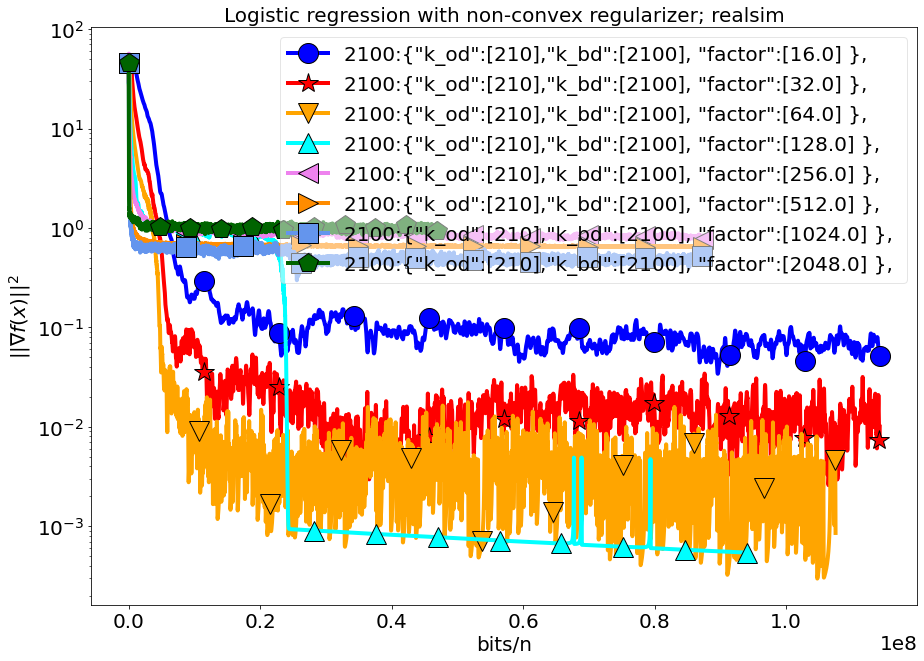

5250:{"k_od":[210],"k_bd":[5250], "factor":[16.0] },  iter:    10001; norms:  8.84e-02  bits/n: 67200000
5250:{"k_od":[210],"k_bd":[5250], "factor":[32.0] },  iter:     5001; norms:  7.84e-03  bits/n: 33600000
5250:{"k_od":[210],"k_bd":[5250], "factor":[64.0] },  iter:     6001; norms:  3.75e-03  bits/n: 40320000
5250:{"k_od":[210],"k_bd":[5250], "factor":[128.0] },  iter:     2001; norms:  8.81e-01  bits/n: 13440000
5250:{"k_od":[210],"k_bd":[5250], "factor":[256.0] },  iter:     5001; norms:  8.81e-01  bits/n: 33600000
5250:{"k_od":[210],"k_bd":[5250], "factor":[512.0] },  iter:     5001; norms:  6.65e-01  bits/n: 33600000
5250:{"k_od":[210],"k_bd":[5250], "factor":[1024.0] },  iter:     5001; norms:  4.87e-01  bits/n: 33600000
5250:{"k_od":[210],"k_bd":[5250], "factor":[2048.0] },  iter:     3001; norms:  9.66e-01  bits/n: 20160000
5250:{"k_od":[210],"k_bd":[5250], "factor":[32.0] }, 


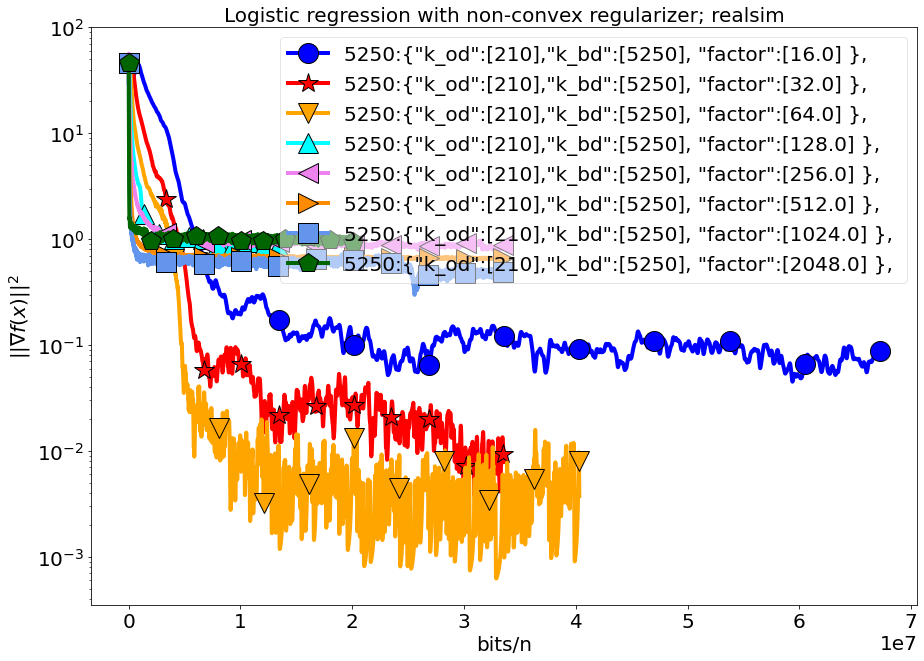

In [123]:
project_path = os.getcwd() + "/"

dataset_ar = ['mushrooms', 'w8a', 'a9a', 'phishing']
dataset_ar = ['realsim']

exps = ["ef21_bc"]
main_title = "comparison_best"

draw = 1          #draw or not
save = 0           #save or not pdf of each plot 
save_separately = 0
print_each_exp = 1

if "ef21_pp" in exps:
    n_ar = [100]
else:
    n_ar = [20]
dict_type_output = 1
    
myrepr = lambda x: repr(round(x, 4)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding
#myrepr = lambda x: repr(round(x, 2)).replace('.',',') if isinstance(x, float) else repr(x) #for some methods we used diffrent rounding

ef21_bc_k_bd_ar_ar = [[210],[1050],[2100],[5250]]

for dataset in dataset_ar:
    print(dataset)
    for ef21_bc_k_bd_ar in ef21_bc_k_bd_ar_ar:
        data_path = project_path + "data_{0}/".format(dataset)
        if save_separately:
            plot_path = project_path + "plot_{0}/".format(dataset)
        else:
            plot_path = project_path + "plot_all-datasets/"  
        ################
        ##EF21 with BC##
        ################
        ef21_bc_k_od_ar = {'mushrooms':[2], 'w8a':[2], 'a9a':[2], 'phishing':[1], 'realsim':[210]}[dataset]
        
        ef21_bc_factor_ar = np.array([16,32,64,128,256,512,1024,2048], dtype=float)
        
        y_axis = 'norms'
        x_axis = 'iteration_bits_od'
        #x_axis = 'iteration_bits_bd'
        #x_axis = 'iteration_epochs'
        #x_axis = 'iteration_comm'

        its_ar = []
        norms_ar= []
        label_ar = []


        exp_ef21_bc_ar = []
        label_ef21_bc_ar = []


        if "ef21_bc" in exps:
            exp_ef21_bc_ar = ["ef21-bc_nw-{0}_{1}x_{2}_{3}".format(n, myrepr(ef21_bc_factor), k_od, k_bd) for n, k_od, k_bd, ef21_bc_factor in itertools.product(n_ar, ef21_bc_k_od_ar, ef21_bc_k_bd_ar, ef21_bc_factor_ar)]
            if dict_type_output:
                label_ef21_bc_ar = [f"{k_bd}:{{\"k_od\":[{k_od}],\"k_bd\":[{k_bd}], \"factor\":[{ef21_bc_factor}] }}, " for n, k_od, k_bd, ef21_bc_factor in itertools.product(n_ar, ef21_bc_k_od_ar, ef21_bc_k_bd_ar, ef21_bc_factor_ar)]
            else:
                label_ef21_bc_ar = ["EF21-BC; WM: Top-{0}; MW: Top-{1}; {2}x".format(k_od, k_bd, ef21_bc_factor) for n, k_od, k_bd, ef21_bc_factor in itertools.product(n_ar, ef21_bc_k_od_ar, ef21_bc_k_bd_ar, ef21_bc_factor_ar)]


        experiment_ar =  exp_ef21_bc_ar
        label_ar = label_ef21_bc_ar

        its_last_value = np.zeros(len(experiment_ar))
        norms_last_value = np.zeros(len(experiment_ar))

        tol = 1e-1
        for i, experiment in enumerate(experiment_ar):
            logs_path = project_path + "logs/logs_{0}_{1}/".format(dataset, experiment)
            logs_file_its = logs_path + x_axis + "_" + experiment + ".npy"    
            if os.path.isfile(logs_file_its):
                its = np.load(logs_file_its)
                if len (its.shape)==2:
                    if its.shape[0] ==1:
                        its = its.flatten()
                    else: 
                        raise ValueError("wrong shape")            
                its_comm  = np.arange(its.shape[0])
                its_ar.append(its)
                norms = np.load(logs_path + y_axis + '_' + experiment+'.npy')
                if len (norms.shape)==2:
                    if norms.shape[0]==1:
                        norms = norms.flatten()
                    else: 
                        raise ValueError("wrong shape")
                norms_ar.append(norms)
                norms_last_value[i] = norms_ar[-1][-1]
                if norms_last_value[i] > tol:
                    its_last_value[i] = np.inf
                else:
                    its_last_value[i] = its_ar[-1][-1]
            else:
                its_ar.append(np.array([-1])) #emplhasising the error
                norms_ar.append(np.array([-1]))
                its_last_value[i] = np.inf #to exclude it from minimization
                norms_last_value[i] = np.inf
                print (logs_path +" "+ experiment+" is not computed")

            if print_each_exp:
                print ("%34s iter: %8d; norms: %9.2e  bits/n: %8d"%(label_ar[i], its_ar[-1].shape[0], norms_ar[-1][-1], its_ar[-1][-1]) )        
        inf_inds = np.argwhere(np.isinf(norms_last_value)).flatten()
        nan_inds = np.argwhere(np.isnan(norms_last_value)).flatten()
        its_last_value[nan_inds] = np.inf
        its_last_value[inf_inds] = np.inf
        it_min = np.argmin (its_last_value)
        #it_min = np.argmin (norms_last_value)
        if dict_type_output:
            print (label_ar[it_min])
        else:
            print ("k_bd = ", ef21_bc_k_bd_ar[0]," MIN: %34s iter: %8d; norms: %9.2e  bits/n: %8d"%(label_ar[it_min], its_ar[it_min].shape[0], norms_ar[it_min][-1], its_last_value[it_min]))
        #print ("Num exps: ",len(label_ar))
        filename = "{0}_{1}.pdf".format(main_title, dataset)
        if draw:
            plot1(its_ar, norms_ar, label_ar, plot_path, dataset, filename=filename, save=save)
            
            



# Some auxillary/backup code

In [ ]:
########
## HB ##
########
hb_factor_ar = np.array([0.125,0.25,0.5, 1,2,4,8,16,32,64,128,256,512,1024,2048], dtype=float)
hb_eta_ar = np.array([0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.99]) # final set for all 
#hb_factor_ar = [1.0]
#hb_eta_ar = np.array([0.2]) # final set for all 
########
## GD ##
########
gd_factor_ar = np.array([0.25,0.5,1,2,4,8,16,32,64,128,256,512,1024,2048], dtype=float)
#gd_factor_ar = [1.0]

## Non-merged plots

In [ ]:
############################
## MAIN PLOTTING FUNCTION ##
############################
def plot1(x_ar, y_ar, label_ar, plot_path, dataset, title=None, xaxis='bits/n', yaxis=r"$\|| \nabla f(x) \||^2$", yscale="log", filename=None, save=0 ):
    size = 20
    marker_size = 20
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'FreeSerif'
    plt.rcParams['lines.linewidth'] = 4
    # plt.rcParams['lines.markersize'] = 10
    plt.rcParams['xtick.labelsize'] = size  # 40
    plt.rcParams['ytick.labelsize'] = size  # 40
    plt.rcParams['legend.fontsize'] = size  # 30
    plt.rcParams['axes.titlesize'] = size  # 40
    plt.rcParams['axes.labelsize'] = size  # 40
    plt.rcParams["figure.figsize"] = [13,9]
    if yscale == "log":
        plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.tight_layout()
    color_ar_1 = ['blue', 'red', 'orange', 'aqua', 'violet']+[ 'darkorange','cornflowerblue', 'darkgreen',
                                  'coral', 'lime',
                                  'darkgreen', 'goldenrod', 'maroon',
                                  'black', 'brown', 'yellowgreen', "purple", "violet", "magenta", "green"
                                  ]
    marker_ar = ["o", "*", "v", "^", "<", ">", "s", "p", "P", "h", "H", "+", "x", "X", "D", "d", "|", "_",1,2,3,4,5,6,7,8,9]
    if title is None:
        title = f"Logistic regression with non-convex regularizer; {dataset}"
    plt.title(title)
    for i in range (len(x_ar)):
        inds = np.arange (x_ar[i].shape[0])
        markers_on = inds[inds % (int(len(inds[:-(1 + 2 * i)]) / 10)) == 0].astype(int)
        plt.plot(x_ar[i], y_ar[i], 'r', label=label_ar[i], color=color_ar_1[i],marker=marker_ar[i], markevery=list(markers_on), markersize=marker_size, markerfacecolor=color_ar_1[i], markeredgecolor = 'black')
    legend = plt.legend(loc="upper right", framealpha=0.5)
    if save:
        plt.savefig(plot_path + filename, bbox_inches='tight')
    plt.show()

In [ ]:
project_path = os.getcwd() + "/"
x_title = {'iteration_bits_od':'bits/n (OD)', 'iteration_bits_bd':'bits/n (BD)','iteration_epochs':'epochs', 'iteration_comm':"communications rounds"}
y_title = {'norms':r"$\|| \nabla f(x) \||^2$"}

#params of choice
dataset_ar = ['mushrooms', 'w8a', 'a9a', 'phishing']
#dataset_ar =['mushrooms']
#dataset_ar = ['w8a']
#dataset_ar = ['a9a']
#dataset_ar =['phishing']

main_title = "comparison_best"
y_axis = 'norms'
x_axis = 'iteration_bits_od'
#x_axis = 'iteration_epochs'
#x_axis = 'iteration_comm'

best_params = 1
draw = 0           #draw or not
save = 0           #save or not pdf of each plot 
save_separately = 0
print_each_exp = 0


#upload_all_params = 1 # needed to check whether all desired params were computed
n_ar = np.array([20], dtype=int)
n = n_ar[0]

exps = ["ef21_mnt", "ef21_fg"]
exps = ["ef21_mnt"]
exps = ["ef21_pp"]
exps = ["ef21_hb", "ef21_fg", "ef21_pp"]
exps = ["ef21_page"]
exps = ["ef21_sgd"]
exps = ["ef21_fg" ]

for dataset in dataset_ar:
    print(dataset)
    data_path = project_path + "data_{0}/".format(dataset)
    if save_separately:
        plot_path = project_path + "plot_{0}/".format(dataset)
    else:
        plot_path = project_path + "plot_all-datasets/"  
    
    #TODO: change to fixed_params approach
    ef21_fg  = {"fixed_params": [],
                "k": [1,2,4,8,16,32,64], 
                "factor":[1,2,4,8,16,32,64,128,256,512,1024,2048]}
    
    ef21_hb  = {"fixed_params": [],
                "k": [1,2,4,8,16], 
                "factor":np.array([1,2,4,8,16,32,64,128,256,512,1024,2048],dtype=float), 
                "eta":np.array([0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.99])}
    
    ef21_pp  = {"fixed_params": [],
                "k": [1,2,4,8,16,32,64], 
                "factor":np.array([1,2,4,8,16,32,64,128,256,512,1024,2048],dtype=float), 
                "prw":[0.95,0.5,0.25,0.125,0.065,0.03] }
    
    ef21_sgd = {"fixed_params": [],
                "k": [1,2,4,8,16], 
                "factor":np.array([0.25,0.5,1,2,4,8,16,32,64,128,256,512,1024,2048],dtype=float), 
                "prb":[0.95,0.5,0.25,0.125,0.065,0.03] }
    
    ef21_page = {"fixed_params": [],
                 "k": [1,2,4,8,16], 
                 "factor":np.array([0.25,0.5,1,2,4,8,16,32,64,128,256,512,1024,2048],dtype=float), 
                 "prb":[0.95,0.5,0.25,0.125,0.065,0.03] }
    
    exp_dicts = {"ef21_fg": ef21_fg, "ef21_hb": ef21_hb, "ef21_pp": ef21_pp, "ef21_sgd": ef21_sgd, "ef21_page": ef21_page}
    
    exp_subdict = sub_dict(exp_dicts, exps)
    
    all_exps_ar, all_labels_ar = set_params (dataset, n_ar, exp_subdict)
    
    #print (all_exps_ar)
    #print (all_labels_ar)
    
    #TODO: add a separate function for cutting
    ub_bits = {'mushrooms':200_000_000, 'w8a':150_000_000, 'a9a':40_000_000, 'phishing':20_000_000}
    
    its_ar, norms_ar = upload_logs (dataset, experiment, all_exps_ar, all_labels_ar, x_axis, y_axis )
    
    filename = "{0}_{1}.pdf".format(main_title, dataset)
    
    if draw:
        plot1(its_ar, norms_ar, label_ar, plot_path, dataset, xaxis=x_title[x_axis] , yaxis=y_title[y_axis], filename=filename, save=save)
    #32,64,16 - 64
    
#plot1(x_ar, y_ar, label_ar, plot_path, dataset, title=None, xaxis='bits/n', yaxis=r"$\|| \nabla f(x) \||^2$", yscale="log", filename=None, save=0 ):

In [174]:
dim_dict = {'mushrooms':112, 'w8a':300, 'a9a':123, 'phishing':68}
arr = np.array([2,4,8,16])
for dataset,dim in dim_dict.items():
    print(dataset)
    print ([(k, int(np.round(k/dim*100,0))) for k in arr])  
    

mushrooms
[(2, 2), (4, 4), (8, 7), (16, 14)]
w8a
[(2, 1), (4, 1), (8, 3), (16, 5)]
a9a
[(2, 2), (4, 3), (8, 7), (16, 13)]
phishing
[(2, 3), (4, 6), (8, 12), (16, 24)]


In [ ]:
(list(dim_dict.values()))
16,16,8,8